In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-14 14:44:33.185499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


# Load data

In [2]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    data = data[:, :, :, -1:]
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f)
    t_star = t_star[-1:]
    
T = 1#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb'][0:2]
ub = dataset['ub'][0:2]
obs_X = dataset['obs_input'][:,0:2]
obs_Y = dataset['obs_output'][:,0:2]
pde_X = dataset['pde'][:,0:2]


In [3]:
data_path = os.path.abspath("turing_model_2.npy")
with open(data_path, 'rb') as f:
    data2 = np.load(f)
    data2 = data2[:, :, :, -1:]
    
data_path = os.path.abspath("turing_t_model_2.npy")
with open(data_path, 'rb') as f:
    t_star2 = np.load(f)
    t_star2 = t_star2[-1:]
    
T2 = 1#t_star2.shape[0]    
    
L2 = 50
x_size2 = data2.shape[1]
y_size2 = data2.shape[2]
N2 = x_size2*y_size2

model_params2 = {'training_data_size': T2*N2,#T*32,
                'pde_data_size': (T2*N2)//(32),
                'boundary_data_size':((x_size2 + y_size2)*T2)//(8)}

dataset2 = create_dataset(data2, t_star2, N2, T2, L2, **model_params2)
lb2 = dataset['lb'][0:2]
ub2 = dataset['ub'][0:2]
obs_X2 = dataset2['obs_input'][:,0:2]
obs_Y2 = dataset2['obs_output'][:,0:2]
pde_X2 = dataset2['pde'][:,0:2]

In [4]:
data_path = os.path.abspath("../turing_FitzHugh_Nagumo.npy")
with open(data_path, 'rb') as f:
    data3 = np.load(f)
    data3 = data3[:, :, :, -1:]
    
data_path = os.path.abspath("../turing_t_FitzHugh_Nagumo.npy")
with open(data_path, 'rb') as f:
    t_star3 = np.load(f) 
    t_star3 = t_star3[-1:]
    
T3 = 1#t_star3.shape[0]    
    
L3 = 1.0
x_size3 = data3.shape[1]
y_size3 = data3.shape[2]
N3 = x_size3*y_size3

model_params3 = {'training_data_size': T3*N3,#T*32,
                'pde_data_size': (T3*N3)//(32),
                'boundary_data_size':((x_size3 + y_size3)*T3)//(8)}

dataset3 = create_dataset(data3, t_star3, N3, T3, L3, **model_params3)
lb3 = dataset3['lb'][0:2]
ub3 = dataset3['ub'][0:2]
obs_X3 = dataset3['obs_input'][:,0:2]
obs_Y3 = dataset3['obs_output'][:,0:2]
pde_X3 = dataset3['pde'][:,0:2]

# FitzHugh Nagumo

# High $\alpha = 0.99$

In [17]:
layers = [2, 64, 64, 64, 64, 2]
pinnFHN_reg_H = tu.NN(layers, lb3, ub3, dtype=tf.float64)
pde_lossFHN_reg_H = FitzHugh_Nagumo_steady(dtype=tf.float64, D_u=1, D_v=0.00028, mu=1.5, init_value=4.0)

modelFHN_reg_H = tu.TINN(pinnFHN_reg_H, 
                   pde_lossFHN_reg_H,                 
                   alpha = 0.99, 
                   print_precision=".8f")

In [18]:
resultsFHN_reg_H = modelFHN_reg_H.train(epochs = 5000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=100,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = True,
                                        sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.44044197
total loss: 38.28521063, total regularisd loss: 38.28521063
obs u loss: 0.45357706, obs v loss: 6.59349464
pde u loss: 31.01086807, pde v loss: 0.22727086
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.97018 epsilon: 3.97008 
Time taken: 23.29s

Start of epoch 100
Training observations acc over epoch: 0.43225056
total loss: 6.98991061, total regularisd loss: 18.92846222
obs u loss: 0.36283824, obs v loss: 6.55317113
pde u loss: 0.00048426, pde v loss: 0.07341697
lambda obs u: 0.39448592, lambda obs v: 2.87315215
lambda pde u: 0.36614934, lambda pde v: 0.36621259
alpha: 3.91951 epsilon: 3.92198 
Time taken: 26.05s

Start of epoch 200
Training observations acc over epoch: 0.43188930
total loss: 7.00974874, total regularisd loss: 23.34384451
obs u loss: 0.36133683, obs v loss: 6.54889144
pde u loss: 0.00073027, pde v loss: 0.09879020
lambda obs u: 0.17468938, 


Start of epoch 2200
Training observations acc over epoch: 0.17814767
total loss: 8.10834351, total regularisd loss: 7.60599901
obs u loss: 0.84337994, obs v loss: 2.00698286
pde u loss: 3.16685092, pde v loss: 2.09112980
lambda obs u: 0.47384740, lambda obs v: 2.39291897
lambda pde u: 0.03161741, lambda pde v: 1.10161623
alpha: 2.56156 epsilon: 8.46304 
Time taken: 19.54s

Start of epoch 2300
Training observations acc over epoch: 0.17730466
total loss: 7.33491756, total regularisd loss: 7.52760006
obs u loss: 0.84126587, obs v loss: 1.99560859
pde u loss: 2.42382723, pde v loss: 2.07421587
lambda obs u: 0.48083000, lambda obs v: 2.38300458
lambda pde u: 0.03095996, lambda pde v: 1.10520546
alpha: 2.61963 epsilon: 8.77033 
Time taken: 19.53s

Start of epoch 2400
Training observations acc over epoch: 0.17726773
total loss: 7.63111022, total regularisd loss: 7.48813111
obs u loss: 0.85428324, obs v loss: 1.98200035
pde u loss: 2.73446499, pde v loss: 2.06036164
lambda obs u: 0.48705212, 


Start of epoch 4400
Training observations acc over epoch: 0.16892514
total loss: 7.87271344, total regularisd loss: 7.01696980
obs u loss: 0.83604796, obs v loss: 1.86675430
pde u loss: 3.22172476, pde v loss: 1.94818643
lambda obs u: 0.55858753, lambda obs v: 2.28320497
lambda pde u: 0.02466255, lambda pde v: 1.13354494
alpha: 2.61635 epsilon: 13.56392 
Time taken: 19.33s

Start of epoch 4500
Training observations acc over epoch: 0.16843644
total loss: 7.55135433, total regularisd loss: 6.99534426
obs u loss: 0.83122227, obs v loss: 1.86376075
pde u loss: 2.91292740, pde v loss: 1.94344391
lambda obs u: 0.55894352, lambda obs v: 2.28228487
lambda pde u: 0.02617721, lambda pde v: 1.13259440
alpha: 2.58971 epsilon: 13.79068 
Time taken: 19.70s

Start of epoch 4600
Training observations acc over epoch: 0.16794565
total loss: 6.67242603, total regularisd loss: 6.95492959
obs u loss: 0.83414955, obs v loss: 1.85298105
pde u loss: 2.03521459, pde v loss: 1.95008084
lambda obs u: 0.56145416

In [23]:
resultsFHN_reg_H2 = modelFHN_reg_H.train(epochs = 5000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=100,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = True,
                                        sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.16741434
total loss: 6.69926500, total regularisd loss: 6.91270649
obs u loss: 0.83107778, obs v loss: 1.84755158
pde u loss: 2.09057906, pde v loss: 1.93005659
lambda obs u: 0.56790123, lambda obs v: 2.27411539
lambda pde u: 0.02627339, lambda pde v: 1.13170999
alpha: 2.46500 epsilon: 14.90171 
Time taken: 0.24s

Start of epoch 100
Training observations acc over epoch: 0.16792729
total loss: 6.70089975, total regularisd loss: 6.90484564
obs u loss: 0.83899037, obs v loss: 1.84784637
pde u loss: 2.09318304, pde v loss: 1.92087997
lambda obs u: 0.57070434, lambda obs v: 2.26868555
lambda pde u: 0.02495563, lambda pde v: 1.13565448
alpha: 2.44258 epsilon: 15.13814 
Time taken: 20.06s

Start of epoch 200
Training observations acc over epoch: 0.16696161
total loss: 7.81889068, total regularisd loss: 6.92438061
obs u loss: 0.82924383, obs v loss: 1.84214204
pde u loss: 3.21498471, pde v loss: 1.93252011
lambda obs u: 0.57251288, lamb


Start of epoch 2200
Training observations acc over epoch: 0.16481328
total loss: 7.59061179, total regularisd loss: 6.80006521
obs u loss: 0.82731138, obs v loss: 1.80970113
pde u loss: 3.06067679, pde v loss: 1.89292249
lambda obs u: 0.57762847, lambda obs v: 2.25628989
lambda pde u: 0.02725823, lambda pde v: 1.13882340
alpha: 1.91135 epsilon: 20.79014 
Time taken: 20.41s

Start of epoch 2300
Training observations acc over epoch: 0.16538280
total loss: 6.33783448, total regularisd loss: 6.75229419
obs u loss: 0.83556864, obs v loss: 1.81055644
pde u loss: 1.81536920, pde v loss: 1.87634020
lambda obs u: 0.57982954, lambda obs v: 2.25235515
lambda pde u: 0.02138426, lambda pde v: 1.14643105
alpha: 1.89865 epsilon: 21.13925 
Time taken: 20.27s

Start of epoch 2400
Training observations acc over epoch: 0.16494812
total loss: 6.37945408, total regularisd loss: 6.75097459
obs u loss: 0.83545495, obs v loss: 1.80371499
pde u loss: 1.85304656, pde v loss: 1.88723758
lambda obs u: 0.57901000


Start of epoch 4400
Training observations acc over epoch: 0.16371086
total loss: 5.61793587, total regularisd loss: 6.63804179
obs u loss: 0.84092083, obs v loss: 1.77845297
pde u loss: 1.14927011, pde v loss: 1.84929195
lambda obs u: 0.58093368, lambda obs v: 2.24326140
lambda pde u: 0.02065179, lambda pde v: 1.15515313
alpha: 1.44593 epsilon: 28.31266 
Time taken: 20.31s

Start of epoch 4500
Training observations acc over epoch: 0.16305637
total loss: 6.48523882, total regularisd loss: 6.64143590
obs u loss: 0.83405260, obs v loss: 1.77484946
pde u loss: 2.02255896, pde v loss: 1.85377780
lambda obs u: 0.58777409, lambda obs v: 2.24228215
lambda pde u: 0.01546350, lambda pde v: 1.15448025
alpha: 1.45560 epsilon: 28.75013 
Time taken: 20.25s

Start of epoch 4600
Training observations acc over epoch: 0.16213149
total loss: 10.56808910, total regularisd loss: 6.76604977
obs u loss: 0.81366222, obs v loss: 1.78044133
pde u loss: 6.10335034, pde v loss: 1.87063521
lambda obs u: 0.5853549

In [26]:
resultsFHN_reg_H3 = modelFHN_reg_H.train(epochs = 5000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=100,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = True,
                                        sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.16205126
total loss: 7.93824022, total regularisd loss: 6.66773810
obs u loss: 0.81717448, obs v loss: 1.77564556
pde u loss: 3.48801980, pde v loss: 1.85740038
lambda obs u: 0.58698020, lambda obs v: 2.24168196
lambda pde u: 0.01962253, lambda pde v: 1.15171531
alpha: 1.39884 epsilon: 30.34955 
Time taken: 0.23s

Start of epoch 100
Training observations acc over epoch: 0.15836608
total loss: 5.26356165, total regularisd loss: 6.61445921
obs u loss: 0.76832660, obs v loss: 1.76553087
pde u loss: 0.82114075, pde v loss: 1.90856343
lambda obs u: 0.54066974, lambda obs v: 2.25676786
lambda pde u: 0.07327427, lambda pde v: 1.12928813
alpha: 1.31752 epsilon: 30.22482 
Time taken: 19.72s

Start of epoch 200
Training observations acc over epoch: 0.16332158
total loss: 5.12624036, total regularisd loss: 6.60765837
obs u loss: 0.84388388, obs v loss: 1.76926143
pde u loss: 0.66515166, pde v loss: 1.84794340
lambda obs u: 0.57004148, lamb


Start of epoch 2200
Training observations acc over epoch: 0.16252375
total loss: 5.07245578, total regularisd loss: 6.55804136
obs u loss: 0.84733814, obs v loss: 1.75304191
pde u loss: 0.63599708, pde v loss: 1.83607865
lambda obs u: 0.56895045, lambda obs v: 2.24211408
lambda pde u: 0.03107109, lambda pde v: 1.15786438
alpha: 1.17172 epsilon: 34.89340 
Time taken: 19.55s

Start of epoch 2300
Training observations acc over epoch: 0.16166230
total loss: 5.35486899, total regularisd loss: 6.55908756
obs u loss: 0.83054322, obs v loss: 1.75605362
pde u loss: 0.93597759, pde v loss: 1.83229456
lambda obs u: 0.58475025, lambda obs v: 2.24072360
lambda pde u: 0.01491296, lambda pde v: 1.15961318
alpha: 1.19073 epsilon: 35.13920 
Time taken: 19.67s

Start of epoch 2400
Training observations acc over epoch: 0.16100362
total loss: 5.97269217, total regularisd loss: 6.55816197
obs u loss: 0.82281721, obs v loss: 1.75324076
pde u loss: 1.56200070, pde v loss: 1.83463349
lambda obs u: 0.58751034


Start of epoch 4400
Training observations acc over epoch: 0.16059403
total loss: 5.19100738, total regularisd loss: 6.51007792
obs u loss: 0.83335213, obs v loss: 1.73615253
pde u loss: 0.79407602, pde v loss: 1.82742670
lambda obs u: 0.58011363, lambda obs v: 2.23950164
lambda pde u: 0.01788678, lambda pde v: 1.16249795
alpha: 1.07959 epsilon: 39.53965 
Time taken: 19.58s

Start of epoch 4500
Training observations acc over epoch: 0.16016479
total loss: 5.75121840, total regularisd loss: 6.51353138
obs u loss: 0.82473856, obs v loss: 1.73789809
pde u loss: 1.36346622, pde v loss: 1.82511553
lambda obs u: 0.58590928, lambda obs v: 2.23871465
lambda pde u: 0.01221152, lambda pde v: 1.16316455
alpha: 1.09474 epsilon: 39.80951 
Time taken: 19.56s

Start of epoch 4600
Training observations acc over epoch: 0.15992595
total loss: 6.49965597, total regularisd loss: 6.52094931
obs u loss: 0.82142451, obs v loss: 1.73739077
pde u loss: 2.11459987, pde v loss: 1.82624082
lambda obs u: 0.58631101

In [27]:
print(pde_lossFHN_reg_H.trainables_str())

alpha: 1.07112 epsilon: 40.82139 


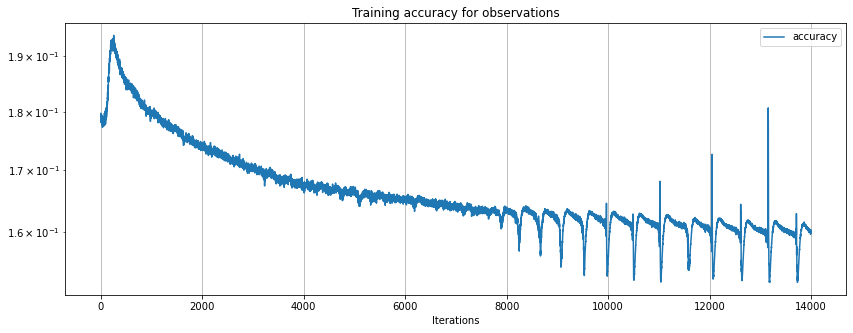

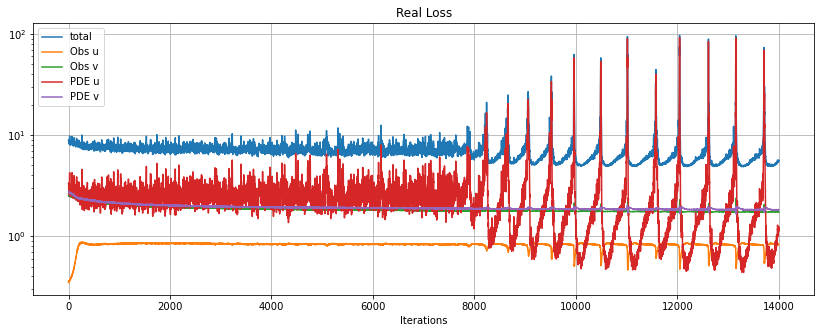

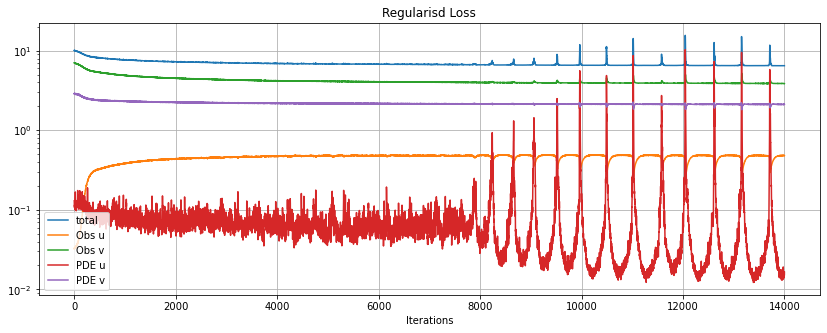

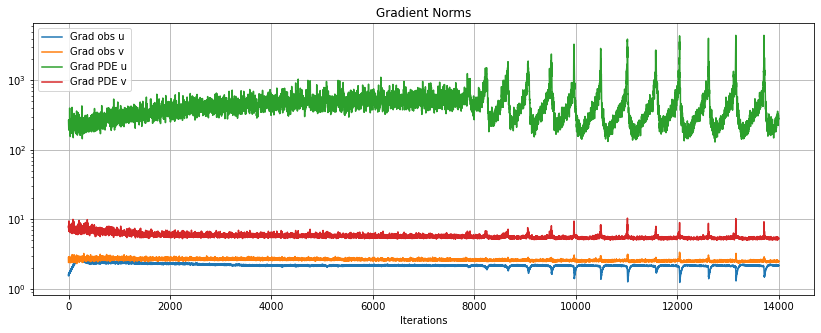

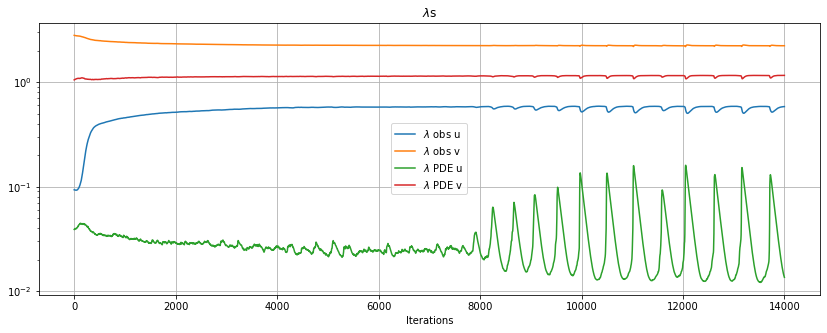

In [28]:
plot_result(merge_dict(resultsFHN_reg_H, resultsFHN_reg_H2, resultsFHN_reg_H3), start=1000)

# Medium $\alpha =.5$

In [29]:
layers = [2, 64, 64, 64, 64, 2]
pinnFHN_reg_H_2 = tu.NN(layers, lb3, ub3, dtype=tf.float64)
pde_lossFHN_reg_H_2 = FitzHugh_Nagumo_steady(dtype=tf.float64, D_u=1, D_v=0.00028, mu=1.5, init_value=4.0)

modelFHN_reg_H_2 = tu.TINN(pinnFHN_reg_H_2, 
                   pde_lossFHN_reg_H_2,                 
                   alpha = 0.5, 
                   print_precision=".8f")

In [30]:
resultsFHN_reg_H_2 = modelFHN_reg_H_2.train(epochs = 10000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=100,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = True,
                                        sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.44331357
total loss: 36.33702564, total regularisd loss: 36.33702564
obs u loss: 0.45408772, obs v loss: 6.63892947
pde u loss: 29.08804689, pde v loss: 0.15596155
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.96714 epsilon: 3.96701 
Time taken: 22.56s

Start of epoch 100
Training observations acc over epoch: 0.42996538
total loss: 7.35090142, total regularisd loss: 25.75471397
obs u loss: 0.35724221, obs v loss: 6.52220329
pde u loss: 0.34763661, pde v loss: 0.12381931
lambda obs u: 0.05024932, lambda obs v: 3.94847389
lambda pde u: 0.00030258, lambda pde v: 0.00097422
alpha: 3.91809 epsilon: 3.91630 
Time taken: 26.20s

Start of epoch 200
Training observations acc over epoch: 0.42877746
total loss: 7.19759368, total regularisd loss: 25.66264444
obs u loss: 0.35397158, obs v loss: 6.50646759
pde u loss: 0.14338906, pde v loss: 0.19376545
lambda obs u: 0.05659175, 


Start of epoch 2200
Training observations acc over epoch: 0.18656398
total loss: 7.42170165, total regularisd loss: 10.49356520
obs u loss: 0.28842061, obs v loss: 2.69660310
pde u loss: 1.82342588, pde v loss: 2.61325207
lambda obs u: 0.06253180, lambda obs v: 2.96477562
lambda pde u: 0.07029068, lambda pde v: 0.90240190
alpha: 3.33489 epsilon: 5.93457 
Time taken: 19.59s

Start of epoch 2300
Training observations acc over epoch: 0.17387180
total loss: 6.98490077, total regularisd loss: 9.80438679
obs u loss: 0.30043995, obs v loss: 2.48150875
pde u loss: 1.63835536, pde v loss: 2.56459671
lambda obs u: 0.07178448, lambda obs v: 2.76674412
lambda pde u: 0.06153856, lambda pde v: 1.09993284
alpha: 3.31834 epsilon: 5.93022 
Time taken: 19.46s

Start of epoch 2400
Training observations acc over epoch: 0.16891015
total loss: 6.83904546, total regularisd loss: 9.18115957
obs u loss: 0.37690595, obs v loss: 2.32565649
pde u loss: 1.70041973, pde v loss: 2.43606330
lambda obs u: 0.10737917,


Start of epoch 4400
Training observations acc over epoch: 0.17552918
total loss: 6.76778470, total regularisd loss: 7.66999371
obs u loss: 0.77426593, obs v loss: 2.03420067
pde u loss: 1.74347132, pde v loss: 2.21584678
lambda obs u: 0.50234540, lambda obs v: 2.41130506
lambda pde u: 0.03464064, lambda pde v: 1.05170890
alpha: 3.07360 epsilon: 6.68484 
Time taken: 19.98s

Start of epoch 4500
Training observations acc over epoch: 0.17620838
total loss: 6.69757935, total regularisd loss: 7.53932736
obs u loss: 0.77966208, obs v loss: 2.03967192
pde u loss: 1.75284769, pde v loss: 2.12539766
lambda obs u: 0.57383197, lambda obs v: 2.31607639
lambda pde u: 0.03338799, lambda pde v: 1.07670365
alpha: 3.10932 epsilon: 6.76315 
Time taken: 20.43s

Start of epoch 4600
Training observations acc over epoch: 0.17414807
total loss: 6.50465927, total regularisd loss: 7.44387476
obs u loss: 0.78761253, obs v loss: 1.99875648
pde u loss: 1.57337541, pde v loss: 2.14491485
lambda obs u: 0.56703999, 


Start of epoch 6600
Training observations acc over epoch: 0.17472351
total loss: 5.91774147, total regularisd loss: 7.32109703
obs u loss: 0.80010668, obs v loss: 1.99546974
pde u loss: 1.12895085, pde v loss: 1.99321421
lambda obs u: 0.53914853, lambda obs v: 2.30208117
lambda pde u: 0.03177104, lambda pde v: 1.12699926
alpha: 3.19330 epsilon: 7.62153 
Time taken: 31.86s

Start of epoch 6700
Training observations acc over epoch: 0.17281164
total loss: 5.89939510, total regularisd loss: 7.23939331
obs u loss: 0.81876132, obs v loss: 1.94622499
pde u loss: 1.09035763, pde v loss: 2.04405116
lambda obs u: 0.55715021, lambda obs v: 2.28699607
lambda pde u: 0.02473513, lambda pde v: 1.13111859
alpha: 3.20165 epsilon: 7.63215 
Time taken: 31.82s

Start of epoch 6800
Training observations acc over epoch: 0.17339385
total loss: 5.94831379, total regularisd loss: 7.18073223
obs u loss: 0.82176132, obs v loss: 1.95254021
pde u loss: 1.16888360, pde v loss: 2.00512866
lambda obs u: 0.58298195, 


Start of epoch 8800
Training observations acc over epoch: 0.17291433
total loss: 6.52960205, total regularisd loss: 7.85769257
obs u loss: 0.65935766, obs v loss: 2.10727137
pde u loss: 1.64384533, pde v loss: 2.11912769
lambda obs u: 0.39951109, lambda obs v: 2.46787880
lambda pde u: 0.05157624, lambda pde v: 1.08103386
alpha: 3.21257 epsilon: 7.76778 
Time taken: 31.87s

Start of epoch 8900
Training observations acc over epoch: 0.17695926
total loss: 6.44103608, total regularisd loss: 7.48449597
obs u loss: 0.82080723, obs v loss: 2.01054065
pde u loss: 1.57192485, pde v loss: 2.03776334
lambda obs u: 0.47837594, lambda obs v: 2.33710468
lambda pde u: 0.03945058, lambda pde v: 1.14506880
alpha: 3.21038 epsilon: 7.77365 
Time taken: 31.75s

Start of epoch 9000
Training observations acc over epoch: 0.17726913
total loss: 6.23673275, total regularisd loss: 7.27242095
obs u loss: 0.84554013, obs v loss: 1.99076585
pde u loss: 1.43765409, pde v loss: 1.96277268
lambda obs u: 0.55431903, 

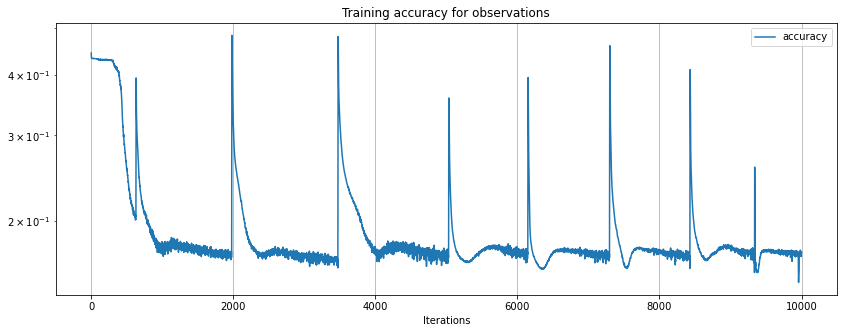

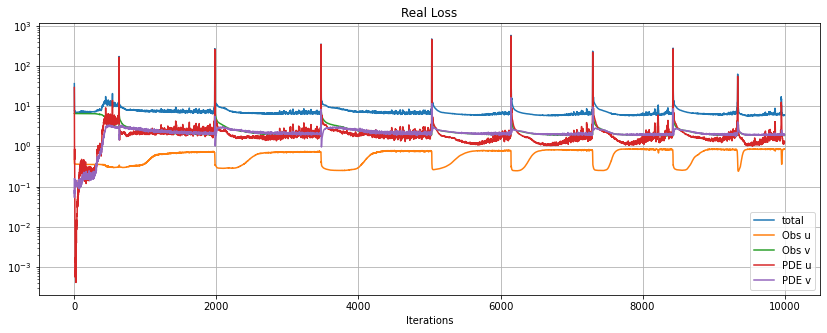

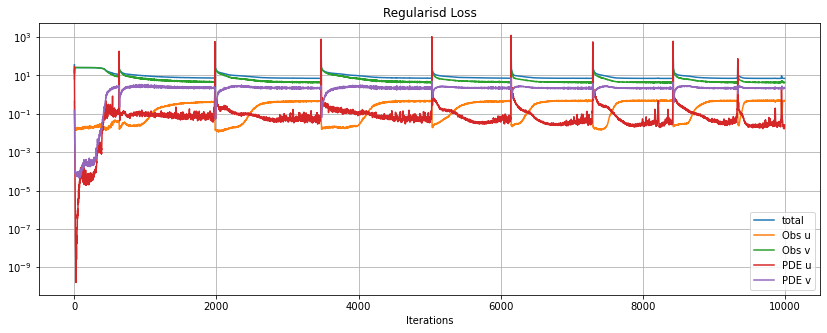

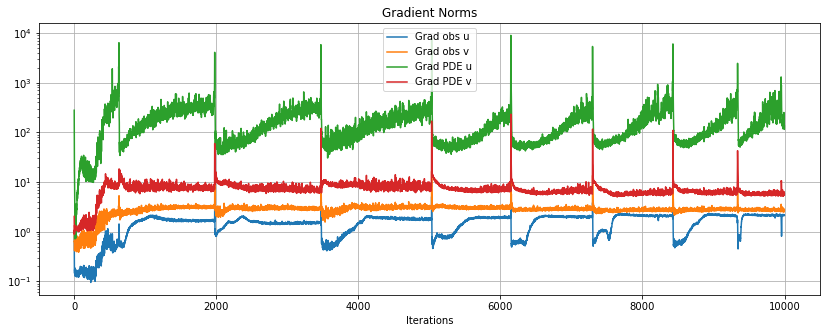

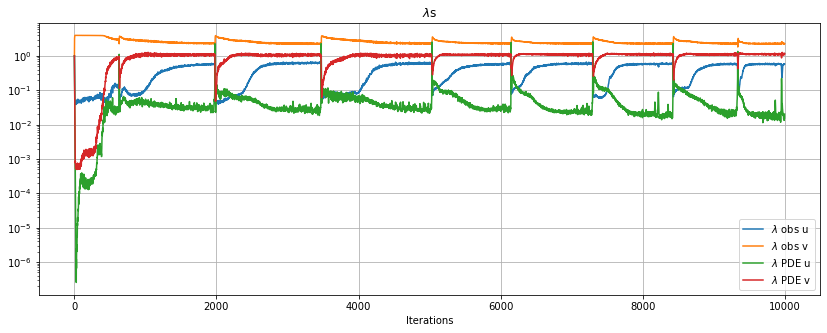

In [31]:
plot_result(merge_dict(resultsFHN_reg_H_2))

# No Regularisation

In [32]:
layers = [2, 64, 64, 64, 64, 2]
pinnFHN_no_reg_H = tu.NN(layers, lb3, ub3, dtype=tf.float64)
pde_lossFHN_no_reg_H = FitzHugh_Nagumo_steady(dtype=tf.float64, D_u=1, D_v=0.00028, mu=1.5, init_value=4.0)

modelFHN_no_reg_H = tu.TINN(pinnFHN_no_reg_H, 
                   pde_lossFHN_no_reg_H,                 
                   print_precision=".8f")

In [33]:
resultsFHN_no_reg_H = modelFHN_no_reg_H.train(epochs = 10000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=100,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = False,
                                        sample_gradients = False,
                                        regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.43828884
total loss: 31.26988596, total regularisd loss: 31.26988596
obs u loss: 0.43801784, obs v loss: 6.57460341
pde u loss: 24.10687758, pde v loss: 0.15038713
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.96561 epsilon: 3.96518 
Time taken: 18.67s

Start of epoch 100
Training observations acc over epoch: 0.43368500
total loss: 6.95927311, total regularisd loss: 6.95927311
obs u loss: 0.36565062, obs v loss: 6.57330942
pde u loss: 0.00033670, pde v loss: 0.01997636
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.91132 epsilon: 3.91101 
Time taken: 17.76s

Start of epoch 200
Training observations acc over epoch: 0.43360227
total loss: 6.95678710, total regularisd loss: 6.95678710
obs u loss: 0.36492092, obs v loss: 6.57271566
pde u loss: 0.00082997, pde v loss: 0.01832055
lambda obs u: 1.00000000, la


Start of epoch 2200
Training observations acc over epoch: 0.38493088
total loss: 6.28182199, total regularisd loss: 6.28182199
obs u loss: 0.31771024, obs v loss: 5.84118399
pde u loss: 0.01328792, pde v loss: 0.10963984
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 1.14958 epsilon: 3.15709 
Time taken: 15.14s

Start of epoch 2300
Training observations acc over epoch: 0.38483208
total loss: 6.27111031, total regularisd loss: 6.27111031
obs u loss: 0.32972761, obs v loss: 5.82758581
pde u loss: 0.01614962, pde v loss: 0.09764727
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 1.04465 epsilon: 3.08243 
Time taken: 15.18s

Start of epoch 2400
Training observations acc over epoch: 0.38256502
total loss: 6.22255552, total regularisd loss: 6.22255552
obs u loss: 0.32454886, obs v loss: 5.79649117
pde u loss: 0.01340431, pde v loss: 0.08811118
lambda obs u: 1.00000000, 


Start of epoch 4400
Training observations acc over epoch: 0.22638039
total loss: 4.62195264, total regularisd loss: 4.62195264
obs u loss: 0.33516987, obs v loss: 3.28691677
pde u loss: 0.07896392, pde v loss: 0.92090208
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 1.58172 epsilon: 2.20358 
Time taken: 15.51s

Start of epoch 4500
Training observations acc over epoch: 0.22553898
total loss: 4.58006212, total regularisd loss: 4.58006212
obs u loss: 0.33392471, obs v loss: 3.27469893
pde u loss: 0.05555017, pde v loss: 0.91588831
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 1.64822 epsilon: 2.22070 
Time taken: 15.49s

Start of epoch 4600
Training observations acc over epoch: 0.22402498
total loss: 4.54582134, total regularisd loss: 4.54582134
obs u loss: 0.33725596, obs v loss: 3.24714340
pde u loss: 0.03825635, pde v loss: 0.92316562
lambda obs u: 1.00000000, 


Start of epoch 6600
Training observations acc over epoch: 0.21439318
total loss: 4.45143196, total regularisd loss: 4.45143196
obs u loss: 0.33540052, obs v loss: 3.09489037
pde u loss: 0.05699604, pde v loss: 0.96414503
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 2.64062 epsilon: 2.57712 
Time taken: 9.69s

Start of epoch 6700
Training observations acc over epoch: 0.21482460
total loss: 4.43664622, total regularisd loss: 4.43664622
obs u loss: 0.33443022, obs v loss: 3.10276334
pde u loss: 0.04753807, pde v loss: 0.95191459
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 2.67442 epsilon: 2.59447 
Time taken: 9.82s

Start of epoch 6800
Training observations acc over epoch: 0.21425289
total loss: 4.47963407, total regularisd loss: 4.47963407
obs u loss: 0.33393722, obs v loss: 3.09410911
pde u loss: 0.09168508, pde v loss: 0.95990267
lambda obs u: 1.00000000, la


Start of epoch 8800
Training observations acc over epoch: 0.21022150
total loss: 4.39335153, total regularisd loss: 4.39335153
obs u loss: 0.33860301, obs v loss: 3.02494097
pde u loss: 0.05813797, pde v loss: 0.97166958
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.21757 epsilon: 2.76890 
Time taken: 15.42s

Start of epoch 8900
Training observations acc over epoch: 0.21047392
total loss: 4.39456231, total regularisd loss: 4.39456231
obs u loss: 0.33604778, obs v loss: 3.03153478
pde u loss: 0.05907547, pde v loss: 0.96790428
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.24064 epsilon: 2.77485 
Time taken: 15.47s

Start of epoch 9000
Training observations acc over epoch: 0.21021511
total loss: 4.38348893, total regularisd loss: 4.38348893
obs u loss: 0.33821355, obs v loss: 3.02522809
pde u loss: 0.05134343, pde v loss: 0.96870385
lambda obs u: 1.00000000, 

In [36]:
resultsFHN_no_reg_H2 = modelFHN_no_reg_H.train(epochs = 10000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=100,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = False,
                                        sample_gradients = False,
                                        regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.20925710
total loss: 4.36101984, total regularisd loss: 4.36101984
obs u loss: 0.33857922, obs v loss: 3.00953404
pde u loss: 0.04569020, pde v loss: 0.96721637
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.45257 epsilon: 2.83354 
Time taken: 0.15s

Start of epoch 100
Training observations acc over epoch: 0.20920983
total loss: 4.35336135, total regularisd loss: 4.35336135
obs u loss: 0.33836518, obs v loss: 3.00899181
pde u loss: 0.03990178, pde v loss: 0.96610258
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.47093 epsilon: 2.83977 
Time taken: 15.35s

Start of epoch 200
Training observations acc over epoch: 0.20867154
total loss: 4.35395825, total regularisd loss: 4.35395825
obs u loss: 0.33939885, obs v loss: 2.99934597
pde u loss: 0.04267103, pde v loss: 0.97254240
lambda obs u: 1.00000000, lambda


Start of epoch 2200
Training observations acc over epoch: 0.20690109
total loss: 4.33474686, total regularisd loss: 4.33474686
obs u loss: 0.34151035, obs v loss: 2.96890711
pde u loss: 0.04663287, pde v loss: 0.97769653
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.82116 epsilon: 2.93140 
Time taken: 15.44s

Start of epoch 2300
Training observations acc over epoch: 0.20739737
total loss: 4.34731217, total regularisd loss: 4.34731217
obs u loss: 0.33903569, obs v loss: 2.97932235
pde u loss: 0.06065083, pde v loss: 0.96830329
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.83516 epsilon: 2.93290 
Time taken: 15.44s

Start of epoch 2400
Training observations acc over epoch: 0.20710453
total loss: 4.35139231, total regularisd loss: 4.35139231
obs u loss: 0.34005605, obs v loss: 2.97361644
pde u loss: 0.06365332, pde v loss: 0.97406650
lambda obs u: 1.00000000, 


Start of epoch 4400
Training observations acc over epoch: 0.20603310
total loss: 4.29545614, total regularisd loss: 4.29545614
obs u loss: 0.34135194, obs v loss: 2.95517743
pde u loss: 0.03007611, pde v loss: 0.96885066
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 4.09658 epsilon: 2.99401 
Time taken: 15.57s

Start of epoch 4500
Training observations acc over epoch: 0.20644267
total loss: 4.37508748, total regularisd loss: 4.37508748
obs u loss: 0.33879021, obs v loss: 2.96429248
pde u loss: 0.10616906, pde v loss: 0.96583573
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 4.10622 epsilon: 2.99361 
Time taken: 15.40s

Start of epoch 4600
Training observations acc over epoch: 0.20597175
total loss: 4.31227043, total regularisd loss: 4.31227043
obs u loss: 0.33901906, obs v loss: 2.95652891
pde u loss: 0.04873015, pde v loss: 0.96799232
lambda obs u: 1.00000000, 


Start of epoch 6600
Training observations acc over epoch: 0.20486397
total loss: 4.33058303, total regularisd loss: 4.33058303
obs u loss: 0.33750216, obs v loss: 2.94032162
pde u loss: 0.08000901, pde v loss: 0.97275025
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 4.30747 epsilon: 3.02013 
Time taken: 15.40s

Start of epoch 6700
Training observations acc over epoch: 0.20483950
total loss: 4.32605427, total regularisd loss: 4.32605427
obs u loss: 0.34272756, obs v loss: 2.93470402
pde u loss: 0.07584695, pde v loss: 0.97277573
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 4.31962 epsilon: 3.02673 
Time taken: 15.40s

Start of epoch 6800
Training observations acc over epoch: 0.20498876
total loss: 4.31560638, total regularisd loss: 4.31560638
obs u loss: 0.33900294, obs v loss: 2.94081742
pde u loss: 0.06820664, pde v loss: 0.96757938
lambda obs u: 1.00000000, 


Start of epoch 8800
Training observations acc over epoch: 0.20402387
total loss: 4.28391260, total regularisd loss: 4.28391260
obs u loss: 0.34360905, obs v loss: 2.92077287
pde u loss: 0.04875915, pde v loss: 0.97077154
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 4.49719 epsilon: 3.03077 
Time taken: 15.40s

Start of epoch 8900
Training observations acc over epoch: 0.20337620
total loss: 4.27166066, total regularisd loss: 4.27166066
obs u loss: 0.34279910, obs v loss: 2.91122021
pde u loss: 0.03815481, pde v loss: 0.97948654
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 4.49869 epsilon: 3.01928 
Time taken: 15.70s

Start of epoch 9000
Training observations acc over epoch: 0.20399161
total loss: 4.28812633, total regularisd loss: 4.28812633
obs u loss: 0.34257631, obs v loss: 2.92128948
pde u loss: 0.05374754, pde v loss: 0.97051300
lambda obs u: 1.00000000, 

In [39]:
resultsFHN_no_reg_H3 = modelFHN_no_reg_H.train(epochs = 50000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=500,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = False,
                                        sample_gradients = False,
                                        regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.20337927
total loss: 4.28746191, total regularisd loss: 4.28746191
obs u loss: 0.33987621, obs v loss: 2.91419233
pde u loss: 0.05568269, pde v loss: 0.97771068
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 4.58944 epsilon: 3.02074 
Time taken: 0.16s

Start of epoch 500
Training observations acc over epoch: 0.20319933
total loss: 4.26610704, total regularisd loss: 4.26610704
obs u loss: 0.34191026, obs v loss: 2.90927891
pde u loss: 0.04010631, pde v loss: 0.97481156
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 4.63217 epsilon: 3.02276 
Time taken: 77.17s

Start of epoch 1000
Training observations acc over epoch: 0.20289887
total loss: 4.27419760, total regularisd loss: 4.27419760
obs u loss: 0.34415884, obs v loss: 2.90222296
pde u loss: 0.05258926, pde v loss: 0.97522655
lambda obs u: 1.00000000, lambd


Start of epoch 11000
Training observations acc over epoch: 0.19965823
total loss: 4.22945988, total regularisd loss: 4.22945988
obs u loss: 0.34685904, obs v loss: 2.84767300
pde u loss: 0.05407430, pde v loss: 0.98085355
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 5.37302 epsilon: 2.95801 
Time taken: 76.92s

Start of epoch 11500
Training observations acc over epoch: 0.19971147
total loss: 4.23148664, total regularisd loss: 4.23148664
obs u loss: 0.34569054, obs v loss: 2.84969324
pde u loss: 0.05613635, pde v loss: 0.97996651
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 5.40001 epsilon: 2.95130 
Time taken: 76.99s

Start of epoch 12000
Training observations acc over epoch: 0.19981295
total loss: 4.29999191, total regularisd loss: 4.29999191
obs u loss: 0.34064726, obs v loss: 2.85635981
pde u loss: 0.11805775, pde v loss: 0.98492709
lambda obs u: 1.0000000


Start of epoch 22000
Training observations acc over epoch: 0.19910941
total loss: 4.26193620, total regularisd loss: 4.26193620
obs u loss: 0.33969034, obs v loss: 2.84606036
pde u loss: 0.09941078, pde v loss: 0.97677472
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 5.92424 epsilon: 2.84298 
Time taken: 76.64s

Start of epoch 22500
Training observations acc over epoch: 0.19869825
total loss: 4.19208565, total regularisd loss: 4.19208565
obs u loss: 0.34657526, obs v loss: 2.83259691
pde u loss: 0.03779279, pde v loss: 0.97512068
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 5.94740 epsilon: 2.83588 
Time taken: 76.44s

Start of epoch 23000
Training observations acc over epoch: 0.19777460
total loss: 4.20428723, total regularisd loss: 4.20428723
obs u loss: 0.34900198, obs v loss: 2.81539175
pde u loss: 0.05127788, pde v loss: 0.98861562
lambda obs u: 1.0000000


Start of epoch 33000
Training observations acc over epoch: 0.19796337
total loss: 4.19082431, total regularisd loss: 4.19082431
obs u loss: 0.34632022, obs v loss: 2.82109392
pde u loss: 0.04399272, pde v loss: 0.97941745
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 6.40144 epsilon: 2.70696 
Time taken: 76.68s

Start of epoch 33500
Training observations acc over epoch: 0.19747603
total loss: 4.19375937, total regularisd loss: 4.19375937
obs u loss: 0.34661831, obs v loss: 2.81299815
pde u loss: 0.04861890, pde v loss: 0.98552401
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 6.42049 epsilon: 2.69976 
Time taken: 76.59s

Start of epoch 34000
Training observations acc over epoch: 0.19798528
total loss: 4.16730993, total regularisd loss: 4.16730993
obs u loss: 0.34825130, obs v loss: 2.81951312
pde u loss: 0.02483067, pde v loss: 0.97471485
lambda obs u: 1.0000000


Start of epoch 44000
Training observations acc over epoch: 0.19706672
total loss: 4.17195161, total regularisd loss: 4.17195161
obs u loss: 0.34591276, obs v loss: 2.80715475
pde u loss: 0.03745980, pde v loss: 0.98142429
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 6.85049 epsilon: 2.58001 
Time taken: 77.85s

Start of epoch 44500
Training observations acc over epoch: 0.19764552
total loss: 4.21837480, total regularisd loss: 4.21837480
obs u loss: 0.34788085, obs v loss: 2.81444732
pde u loss: 0.08127873, pde v loss: 0.97476790
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 6.87241 epsilon: 2.57847 
Time taken: 77.35s

Start of epoch 45000
Training observations acc over epoch: 0.19727640
total loss: 4.18025030, total regularisd loss: 4.18025030
obs u loss: 0.34627062, obs v loss: 2.81015192
pde u loss: 0.04298266, pde v loss: 0.98084509
lambda obs u: 1.0000000

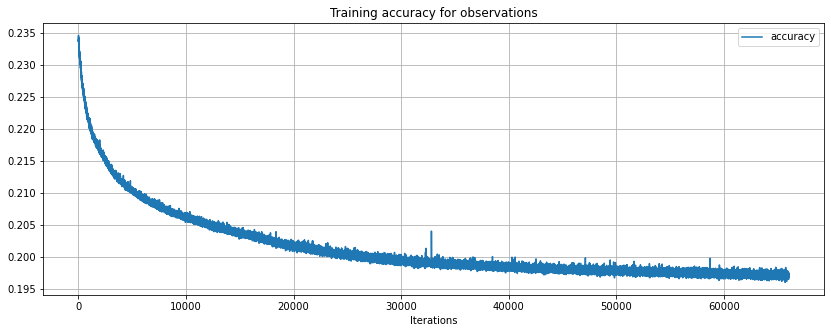

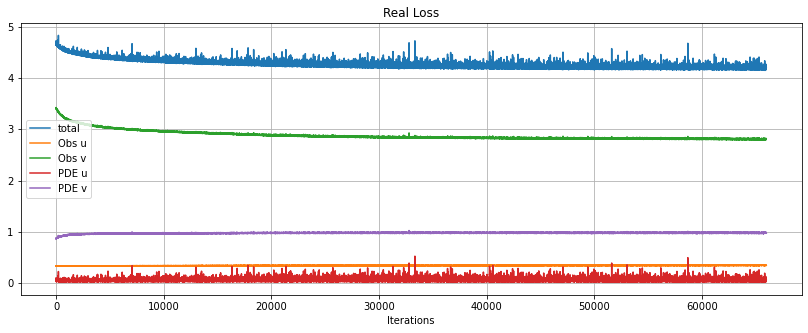

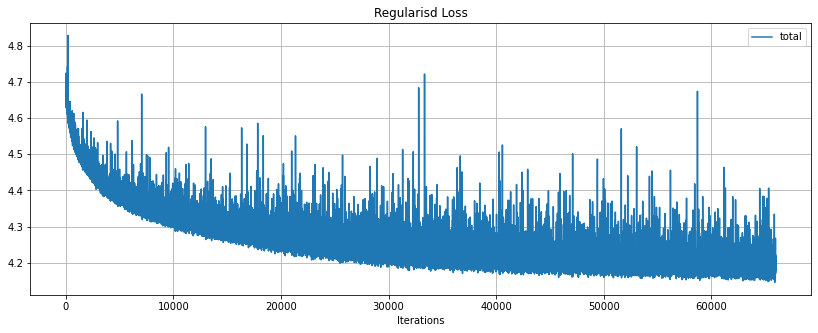

In [40]:
plot_result(merge_dict(resultsFHN_no_reg_H, resultsFHN_no_reg_H2, resultsFHN_no_reg_H3), start=4000, yscale='linear')

# No requlirasation, correct $D_u = 0.05$

In [41]:
layers = [2, 64, 64, 64, 64, 2]
pinnFHN_no_reg_H_2 = tu.NN(layers, lb3, ub3, dtype=tf.float64)
pde_lossFHN_no_reg_H_2 = FitzHugh_Nagumo_steady(dtype=tf.float64, D_u=0.05, D_v=0.00028, mu=1.5, init_value=4.0)

modelFHN_no_reg_H_2 = tu.TINN(pinnFHN_no_reg_H_2, 
                   pde_lossFHN_no_reg_H_2,                 
                   print_precision=".8f")

In [42]:
resultsFHN_no_reg_H_2 = modelFHN_no_reg_H_2.train(epochs = 10000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=100,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = False,
                                        sample_gradients = False,
                                        regularise=False)


Start of epoch 0
Training observations acc over epoch: 0.44084263
total loss: 29.33454079, total regularisd loss: 29.33454079
obs u loss: 0.44112802, obs v loss: 6.61235406
pde u loss: 21.97940695, pde v loss: 0.30165176
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.96908 epsilon: 3.97073 
Time taken: 19.84s

Start of epoch 100
Training observations acc over epoch: 0.43357259
total loss: 6.95896259, total regularisd loss: 6.95896259
obs u loss: 0.36621823, obs v loss: 6.57094317
pde u loss: 0.00037099, pde v loss: 0.02143020
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.91448 epsilon: 3.92435 
Time taken: 17.61s

Start of epoch 200
Training observations acc over epoch: 0.43336397
total loss: 6.95684931, total regularisd loss: 6.95684931
obs u loss: 0.36606144, obs v loss: 6.56776253
pde u loss: 0.00028790, pde v loss: 0.02273745
lambda obs u: 1.00000000, la


Start of epoch 2200
Training observations acc over epoch: 0.19855744
total loss: 3.98613696, total regularisd loss: 3.98613696
obs u loss: 0.22909370, obs v loss: 2.94782550
pde u loss: 0.05678592, pde v loss: 0.75243184
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 0.72394 epsilon: 7.69123 
Time taken: 15.35s

Start of epoch 2300
Training observations acc over epoch: 0.19478635
total loss: 3.93516369, total regularisd loss: 3.93516369
obs u loss: 0.23052733, obs v loss: 2.88605416
pde u loss: 0.06307375, pde v loss: 0.75550845
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 0.71298 epsilon: 8.22673 
Time taken: 15.35s

Start of epoch 2400
Training observations acc over epoch: 0.19171093
total loss: 3.86577070, total regularisd loss: 3.86577070
obs u loss: 0.23102787, obs v loss: 2.83634700
pde u loss: 0.04228654, pde v loss: 0.75610928
lambda obs u: 1.00000000, 


Start of epoch 4400
Training observations acc over epoch: 0.16969633
total loss: 3.48498310, total regularisd loss: 3.48498310
obs u loss: 0.25663528, obs v loss: 2.45850596
pde u loss: 0.03834344, pde v loss: 0.73149842
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 0.68307 epsilon: 16.35866 
Time taken: 15.23s

Start of epoch 4500
Training observations acc over epoch: 0.16924201
total loss: 3.51405516, total regularisd loss: 3.51405516
obs u loss: 0.25226698, obs v loss: 2.45560544
pde u loss: 0.07529009, pde v loss: 0.73089264
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 0.68395 epsilon: 16.63910 
Time taken: 15.42s

Start of epoch 4600
Training observations acc over epoch: 0.16863510
total loss: 3.49547856, total regularisd loss: 3.49547856
obs u loss: 0.25388402, obs v loss: 2.44427739
pde u loss: 0.06828036, pde v loss: 0.72903679
lambda obs u: 1.00000000


Start of epoch 6600
Training observations acc over epoch: 0.16290104
total loss: 3.35813086, total regularisd loss: 3.35813086
obs u loss: 0.26602425, obs v loss: 2.34039227
pde u loss: 0.05428101, pde v loss: 0.69743333
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 0.68994 epsilon: 21.49959 
Time taken: 15.39s

Start of epoch 6700
Training observations acc over epoch: 0.16255021
total loss: 3.37179843, total regularisd loss: 3.37179843
obs u loss: 0.27132678, obs v loss: 2.32947664
pde u loss: 0.07297810, pde v loss: 0.69801692
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 0.69037 epsilon: 21.69458 
Time taken: 15.50s

Start of epoch 6800
Training observations acc over epoch: 0.16289517
total loss: 3.54593062, total regularisd loss: 3.54593062
obs u loss: 0.26828906, obs v loss: 2.33803360
pde u loss: 0.24630961, pde v loss: 0.69329835
lambda obs u: 1.00000000


Start of epoch 8800
Training observations acc over epoch: 0.15939742
total loss: 3.29479550, total regularisd loss: 3.29479550
obs u loss: 0.27979922, obs v loss: 2.27055960
pde u loss: 0.06625337, pde v loss: 0.67818330
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 0.69785 epsilon: 24.93272 
Time taken: 15.22s

Start of epoch 8900
Training observations acc over epoch: 0.15907764
total loss: 3.25431436, total regularisd loss: 3.25431436
obs u loss: 0.28024665, obs v loss: 2.26499572
pde u loss: 0.03086678, pde v loss: 0.67820521
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 0.69790 epsilon: 25.07141 
Time taken: 15.41s

Start of epoch 9000
Training observations acc over epoch: 0.15932690
total loss: 3.30139546, total regularisd loss: 3.30139546
obs u loss: 0.28060560, obs v loss: 2.26862484
pde u loss: 0.07907175, pde v loss: 0.67309327
lambda obs u: 1.00000000

In [53]:
(0.28277605+2.24710444)/16

0.158117530625

In [55]:

pinntest = tu.NN([2, 128, 128, 128, 128, 2], lb3, ub3, dtype=tf.float64)
r = 0
for t in pinntest.trainable_variables:
    r += t.shape[0]*t.shape[1]
print(r)

50178


In [54]:
r = 0
for t in pinnFHN_reg_H2.trainable_variables:
    r += t.shape[0]*t.shape[1]
print(r)

12802


In [45]:
layers = [2, 64, 64, 64, 64, 2]
pinnFHN_reg_H2 = tu.NN(layers, lb3, ub3, dtype=tf.float64)
pde_lossFHN_reg_H2 = FitzHugh_Nagumo_steady(dtype=tf.float64, D_u=.05, D_v=0.00028, init_value=4.0)

modelFHN_reg_H2 = tu.TINN(pinnFHN_reg_H2, 
                   pde_lossFHN_reg_H2,                 
                   print_precision=".8f")

In [46]:
resultsFHN_reg_H2_1 = modelFHN_reg_H2.train(epochs = 15000,
                                        batch_size = 512,
                                        X = obs_X3,
                                        Y = obs_Y3,
                                        print_interval=200,
                                        stop_threshold = 1e-5,
                                        shuffle = True,
                                        sample_losses = True,              
                                        sample_regularisations = True,
                                        sample_gradients = True, 
                                        regularise=True)


Start of epoch 0
Training observations acc over epoch: 0.51167160
total loss: 17.17680930, total regularisd loss: 17.17680930
obs u loss: 0.12540999, obs v loss: 1.92127644
pde u loss: 14.79585651, pde v loss: 0.33426637
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
alpha: 3.99342 epsilon: 3.99332 mu: 3.99323 
Time taken: 40.61s

Start of epoch 200
Training observations acc over epoch: 0.49668148
total loss: 2.38169847, total regularisd loss: 7.60129011
obs u loss: 0.07720333, obs v loss: 1.90952259
pde u loss: 0.10725524, pde v loss: 0.28771730
lambda obs u: 0.02253090, lambda obs v: 3.97151430
lambda pde u: 0.00040732, lambda pde v: 0.00554748
alpha: 3.93571 epsilon: 3.93413 mu: 3.89466 
Time taken: 28.27s

Start of epoch 400
Training observations acc over epoch: 0.49621245
total loss: 2.38750873, total regularisd loss: 7.59207037
obs u loss: 0.07695348, obs v loss: 1.90789632
pde u loss: 0.11587236, pde v loss: 0.28678657
lamb


Start of epoch 4400
Training observations acc over epoch: 0.09541266
total loss: 0.86512968, total regularisd loss: 1.24615962
obs u loss: 0.04273930, obs v loss: 0.33891134
pde u loss: 0.18118698, pde v loss: 0.30229206
lambda obs u: 0.17812114, lambda obs v: 2.82482095
lambda pde u: 0.16347433, lambda pde v: 0.83358358
alpha: 3.58395 epsilon: 1.98960 mu: 0.00000 
Time taken: 17.23s

Start of epoch 4600
Training observations acc over epoch: 0.09029053
total loss: 0.80098468, total regularisd loss: 1.15587526
obs u loss: 0.04245130, obs v loss: 0.31871082
pde u loss: 0.15876851, pde v loss: 0.28105404
lambda obs u: 0.20586424, lambda obs v: 2.57178512
lambda pde u: 0.19739888, lambda pde v: 1.02495176
alpha: 3.36968 epsilon: 1.87921 mu: 0.00000 
Time taken: 17.29s

Start of epoch 4800
Training observations acc over epoch: 0.08746524
total loss: 0.78302420, total regularisd loss: 1.11139101
obs u loss: 0.04138130, obs v loss: 0.30847966
pde u loss: 0.16375431, pde v loss: 0.26940892
la


Start of epoch 8800
Training observations acc over epoch: 0.05951919
total loss: 0.54850284, total regularisd loss: 0.72113372
obs u loss: 0.04534024, obs v loss: 0.19273652
pde u loss: 0.12606662, pde v loss: 0.18435947
lambda obs u: 0.19496846, lambda obs v: 2.42426031
lambda pde u: 0.19920487, lambda pde v: 1.18156636
alpha: 1.19732 epsilon: 5.44714 mu: 0.00000 
Time taken: 17.11s

Start of epoch 9000
Training observations acc over epoch: 0.05884416
total loss: 0.53909009, total regularisd loss: 0.71372712
obs u loss: 0.04594411, obs v loss: 0.18943253
pde u loss: 0.11785645, pde v loss: 0.18585700
lambda obs u: 0.19913778, lambda obs v: 2.43465518
lambda pde u: 0.15735801, lambda pde v: 1.20884902
alpha: 1.20840 epsilon: 5.44872 mu: 0.00000 
Time taken: 17.15s

Start of epoch 9200
Training observations acc over epoch: 0.05846840
total loss: 0.53401158, total regularisd loss: 0.70686368
obs u loss: 0.04619588, obs v loss: 0.18767771
pde u loss: 0.11423388, pde v loss: 0.18590410
la


Start of epoch 13200
Training observations acc over epoch: 0.05483728
total loss: 0.51185411, total regularisd loss: 0.65383045
obs u loss: 0.04447045, obs v loss: 0.17487869
pde u loss: 0.12345229, pde v loss: 0.16905269
lambda obs u: 0.22637770, lambda obs v: 2.34652284
lambda pde u: 0.19515912, lambda pde v: 1.23194034
alpha: 1.18941 epsilon: 5.98038 mu: 0.00000 
Time taken: 17.35s

Start of epoch 13400
Training observations acc over epoch: 0.05401830
total loss: 0.48940635, total regularisd loss: 0.63905486
obs u loss: 0.04471778, obs v loss: 0.17135544
pde u loss: 0.10583592, pde v loss: 0.16749721
lambda obs u: 0.23767137, lambda obs v: 2.36113706
lambda pde u: 0.15651272, lambda pde v: 1.24467885
alpha: 1.20351 epsilon: 5.98288 mu: 0.00000 
Time taken: 17.32s

Start of epoch 13600
Training observations acc over epoch: 0.05325579
total loss: 0.48145601, total regularisd loss: 0.63136039
obs u loss: 0.04491862, obs v loss: 0.16810453
pde u loss: 0.09918917, pde v loss: 0.16924370

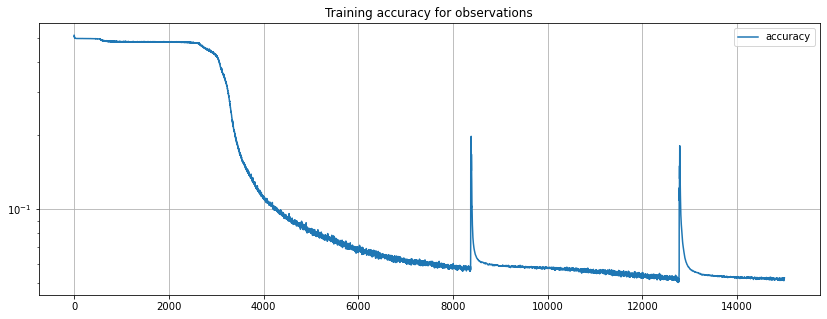

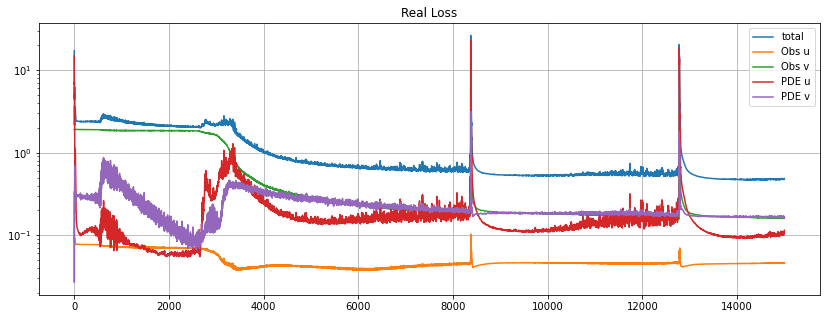

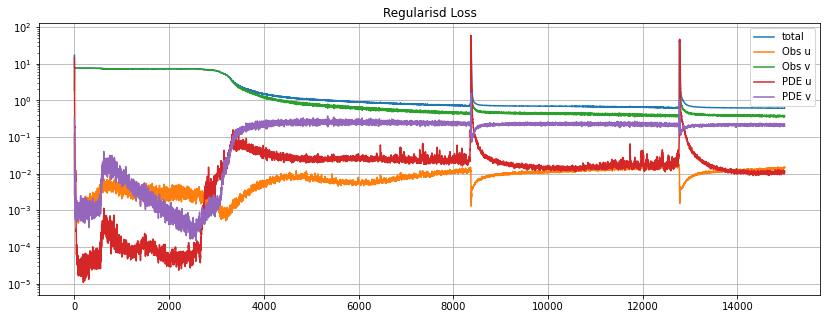

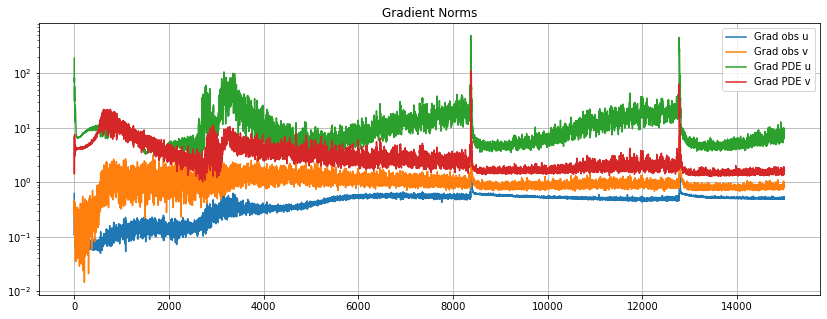

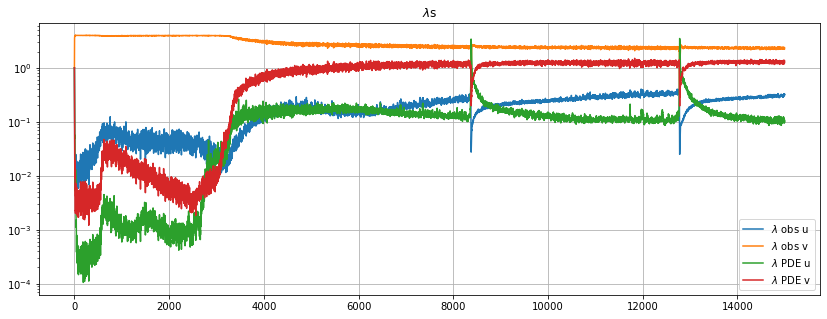

In [47]:
plot_result(resultsFHN_reg_H2_1)

# Test 

In [30]:
pinn2 = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss2 = ASDM(dtype=tf.float64, D_a=.005, D_s=.2)

In [31]:
model2 = tu.TINN(pinn2, 
                pde_loss2, 
                extra_loss = [],                 
                alpha = 0.5, 
                print_precision=".8f")

In [32]:
results2 = model2.train(epochs = 500,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 6.93301392
total loss: 25308.63556755, total regularisd loss: 25308.63556755
obs u loss: 578.20151485, obs v loss: 13620.60675684
pde u loss: 471.13553889, pde v loss: 10638.69175697
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
sigma_a: 10.03101 sigma_s: 8.42518 mu_a: 9.81703 rho_a: 10.29893 
rho_s: 11.86446 kappa_a: 8.03996 
Time taken: 53.10s

Start of epoch 1
Training observations acc over epoch: 4.11574793
total loss: 11717.61909781, total regularisd loss: 11717.61909781
obs u loss: 581.11223539, obs v loss: 7847.94283357
pde u loss: 0.60910465, pde v loss: 3287.95492420
lambda obs u: 0.57718053, lambda obs v: 2.15375575
lambda pde u: 0.50000034, lambda pde v: 0.76906338
sigma_a: 10.07836 sigma_s: 7.60497 mu_a: 9.72926 rho_a: 10.45042 
rho_s: 12.67493 kappa_a: 7.09011 
Time taken: 33.04s

Start of epoch 2
Training observations acc over epoch: 1.30197418
total loss: 7489.

Training observations acc over epoch: 0.13248640
total loss: 335.46644088, total regularisd loss: 977.49023025
obs u loss: 247.81182993, obs v loss: 23.52054550
pde u loss: 50.89737544, pde v loss: 13.23669002
lambda obs u: 3.94001799, lambda obs v: 0.05445077
lambda pde u: 0.00453655, lambda pde v: 0.00099468
sigma_a: 8.45881 sigma_s: 4.32865 mu_a: 10.99774 rho_a: 9.04756 
rho_s: 15.36994 kappa_a: 3.50924 
Time taken: 26.45s

Start of epoch 20
Training observations acc over epoch: 0.13250303
total loss: 335.23305569, total regularisd loss: 978.04089367
obs u loss: 247.84574331, obs v loss: 23.52040271
pde u loss: 50.81329799, pde v loss: 13.05361168
lambda obs u: 3.93908291, lambda obs v: 0.05558466
lambda pde u: 0.00436293, lambda pde v: 0.00096949
sigma_a: 8.41606 sigma_s: 4.33752 mu_a: 10.98324 rho_a: 9.05985 
rho_s: 15.35784 kappa_a: 3.50316 
Time taken: 26.58s

Start of epoch 21
Training observations acc over epoch: 0.13250160
total loss: 338.57663118, total regularisd loss: 977.

Training observations acc over epoch: 0.13239650
total loss: 328.64577474, total regularisd loss: 976.49544028
obs u loss: 247.75789051, obs v loss: 23.39017833
pde u loss: 43.32645385, pde v loss: 14.17125205
lambda obs u: 3.93623551, lambda obs v: 0.05882090
lambda pde u: 0.00397755, lambda pde v: 0.00096603
sigma_a: 7.65072 sigma_s: 4.55446 mu_a: 10.64697 rho_a: 9.35086 
rho_s: 14.33160 kappa_a: 2.99510 
Time taken: 26.14s

Start of epoch 39
Training observations acc over epoch: 0.13237493
total loss: 326.93903167, total regularisd loss: 976.80915334
obs u loss: 247.76335623, obs v loss: 23.34053176
pde u loss: 42.29824921, pde v loss: 13.53689446
lambda obs u: 3.93557332, lambda obs v: 0.05955009
lambda pde u: 0.00394850, lambda pde v: 0.00092809
sigma_a: 7.61056 sigma_s: 4.57388 mu_a: 10.62411 rho_a: 9.37004 
rho_s: 14.25950 kappa_a: 2.96138 
Time taken: 25.99s

Start of epoch 40
Training observations acc over epoch: 0.13239728
total loss: 329.76647645, total regularisd loss: 976.

Training observations acc over epoch: 0.13229589
total loss: 323.81060110, total regularisd loss: 975.34143771
obs u loss: 247.75336216, obs v loss: 23.18867497
pde u loss: 37.78627438, pde v loss: 15.08228959
lambda obs u: 3.92953633, lambda obs v: 0.06587139
lambda pde u: 0.00358341, lambda pde v: 0.00100886
sigma_a: 6.71111 sigma_s: 4.82393 mu_a: 10.29403 rho_a: 9.61605 
rho_s: 12.96031 kappa_a: 2.41265 
Time taken: 26.12s

Start of epoch 58
Training observations acc over epoch: 0.13226473
total loss: 321.24592919, total regularisd loss: 975.09827805
obs u loss: 247.72121370, obs v loss: 23.15709361
pde u loss: 35.95368345, pde v loss: 14.41393844
lambda obs u: 3.92776238, lambda obs v: 0.06756052
lambda pde u: 0.00366327, lambda pde v: 0.00101383
sigma_a: 6.65001 sigma_s: 4.83531 mu_a: 10.28237 rho_a: 9.62084 
rho_s: 12.88723 kappa_a: 2.38910 
Time taken: 26.41s

Start of epoch 59
Training observations acc over epoch: 0.13228895
total loss: 321.91581152, total regularisd loss: 974.

Training observations acc over epoch: 0.13219121
total loss: 318.49665431, total regularisd loss: 974.17500111
obs u loss: 247.70692529, obs v loss: 23.02068433
pde u loss: 31.97941255, pde v loss: 15.78963214
lambda obs u: 3.92971230, lambda obs v: 0.06623347
lambda pde u: 0.00301459, lambda pde v: 0.00103963
sigma_a: 5.67245 sigma_s: 5.05764 mu_a: 9.96054 rho_a: 9.79129 
rho_s: 11.55424 kappa_a: 1.90166 
Time taken: 26.16s

Start of epoch 77
Training observations acc over epoch: 0.13217030
total loss: 313.89163470, total regularisd loss: 974.96292957
obs u loss: 247.68723591, obs v loss: 22.99768192
pde u loss: 27.95815095, pde v loss: 15.24856592
lambda obs u: 3.92476170, lambda obs v: 0.07118655
lambda pde u: 0.00298588, lambda pde v: 0.00106586
sigma_a: 5.62906 sigma_s: 5.08924 mu_a: 9.93008 rho_a: 9.81329 
rho_s: 11.45805 kappa_a: 1.86533 
Time taken: 26.22s

Start of epoch 78
Training observations acc over epoch: 0.13221446
total loss: 319.47903179, total regularisd loss: 974.13

Training observations acc over epoch: 0.13211776
total loss: 309.39701695, total regularisd loss: 976.44053774
obs u loss: 247.70752725, obs v loss: 22.86970351
pde u loss: 23.32072727, pde v loss: 15.49905892
lambda obs u: 3.93130881, lambda obs v: 0.06555709
lambda pde u: 0.00217352, lambda pde v: 0.00096057
sigma_a: 4.65297 sigma_s: 5.17091 mu_a: 9.64395 rho_a: 9.88701 
rho_s: 10.29439 kappa_a: 1.52680 
Time taken: 26.17s

Start of epoch 96
Training observations acc over epoch: 0.13209674
total loss: 308.63773823, total regularisd loss: 975.28576309
obs u loss: 247.68414433, obs v loss: 22.84995028
pde u loss: 23.35352829, pde v loss: 14.75011533
lambda obs u: 3.92996370, lambda obs v: 0.06680362
lambda pde u: 0.00228995, lambda pde v: 0.00094273
sigma_a: 4.60676 sigma_s: 5.19419 mu_a: 9.61692 rho_a: 9.90009 
rho_s: 10.21367 kappa_a: 1.50569 
Time taken: 25.81s

Start of epoch 97
Training observations acc over epoch: 0.13217834
total loss: 314.87258640, total regularisd loss: 975.09

Training observations acc over epoch: 0.13205898
total loss: 303.12114099, total regularisd loss: 976.52498392
obs u loss: 247.69175475, obs v loss: 22.76520805
pde u loss: 18.59884139, pde v loss: 14.06533681
lambda obs u: 3.93082047, lambda obs v: 0.06672301
lambda pde u: 0.00159197, lambda pde v: 0.00086454
sigma_a: 3.69763 sigma_s: 5.16383 mu_a: 9.29228 rho_a: 9.95147 
rho_s: 9.19548 kappa_a: 1.25960 
Time taken: 26.53s

Start of epoch 115
Training observations acc over epoch: 0.13210183
total loss: 307.09312803, total regularisd loss: 975.28900381
obs u loss: 247.71394192, obs v loss: 22.83062786
pde u loss: 20.67975486, pde v loss: 15.86880340
lambda obs u: 3.93874639, lambda obs v: 0.05891729
lambda pde u: 0.00151908, lambda pde v: 0.00081723
sigma_a: 3.65853 sigma_s: 5.16303 mu_a: 9.26730 rho_a: 9.95724 
rho_s: 9.13757 kappa_a: 1.24961 
Time taken: 26.32s

Start of epoch 116
Training observations acc over epoch: 0.13206504
total loss: 304.00371995, total regularisd loss: 976.97

Training observations acc over epoch: 0.13203797
total loss: 299.24113061, total regularisd loss: 978.49539758
obs u loss: 247.67311442, obs v loss: 22.74073576
pde u loss: 15.52194556, pde v loss: 13.30533488
lambda obs u: 3.94110930, lambda obs v: 0.05715588
lambda pde u: 0.00102497, lambda pde v: 0.00070985
sigma_a: 2.91919 sigma_s: 5.03505 mu_a: 8.92096 rho_a: 9.99711 
rho_s: 8.30811 kappa_a: 1.10618 
Time taken: 26.61s

Start of epoch 134
Training observations acc over epoch: 0.13204472
total loss: 300.44293557, total regularisd loss: 977.44320153
obs u loss: 247.67551510, obs v loss: 22.75197171
pde u loss: 16.53089905, pde v loss: 13.48454970
lambda obs u: 3.94109714, lambda obs v: 0.05718825
lambda pde u: 0.00102544, lambda pde v: 0.00068916
sigma_a: 2.86486 sigma_s: 4.99682 mu_a: 8.91294 rho_a: 9.98635 
rho_s: 8.29289 kappa_a: 1.09907 
Time taken: 26.00s

Start of epoch 135
Training observations acc over epoch: 0.13205437
total loss: 299.82823897, total regularisd loss: 977.48

Training observations acc over epoch: 0.13200575
total loss: 294.68243747, total regularisd loss: 977.21020692
obs u loss: 247.64243480, obs v loss: 22.70520337
pde u loss: 13.29526805, pde v loss: 11.03953125
lambda obs u: 3.93933750, lambda obs v: 0.05932029
lambda pde u: 0.00073207, lambda pde v: 0.00061014
sigma_a: 2.22984 sigma_s: 4.75510 mu_a: 8.54067 rho_a: 10.03260 
rho_s: 7.57602 kappa_a: 1.02429 
Time taken: 26.05s

Start of epoch 153
Training observations acc over epoch: 0.13202131
total loss: 296.37345375, total regularisd loss: 976.89872898
obs u loss: 247.63863397, obs v loss: 22.74091006
pde u loss: 14.05484825, pde v loss: 11.93906146
lambda obs u: 3.94291864, lambda obs v: 0.05580141
lambda pde u: 0.00068306, lambda pde v: 0.00059688
sigma_a: 2.19625 sigma_s: 4.73392 mu_a: 8.51896 rho_a: 10.03538 
rho_s: 7.53946 kappa_a: 1.01874 
Time taken: 26.08s

Start of epoch 154
Training observations acc over epoch: 0.13202500
total loss: 295.78253444, total regularisd loss: 977.

Training observations acc over epoch: 0.13201109
total loss: 296.93089614, total regularisd loss: 979.15121210
obs u loss: 247.55578669, obs v loss: 22.80312034
pde u loss: 13.97243146, pde v loss: 12.59955764
lambda obs u: 3.95359485, lambda obs v: 0.04529440
lambda pde u: 0.00054762, lambda pde v: 0.00056313
sigma_a: 1.69607 sigma_s: 4.38095 mu_a: 8.10332 rho_a: 10.11126 
rho_s: 6.93966 kappa_a: 1.00511 
Time taken: 26.38s

Start of epoch 172
Training observations acc over epoch: 0.13200891
total loss: 295.88847485, total regularisd loss: 979.75519980
obs u loss: 247.54890527, obs v loss: 22.80516838
pde u loss: 13.02249484, pde v loss: 12.51190635
lambda obs u: 3.95489341, lambda obs v: 0.04400944
lambda pde u: 0.00053202, lambda pde v: 0.00056513
sigma_a: 1.69395 sigma_s: 4.38139 mu_a: 8.05852 rho_a: 10.13618 
rho_s: 6.88317 kappa_a: 1.00425 
Time taken: 26.41s

Start of epoch 173
Training observations acc over epoch: 0.13199714
total loss: 297.15343936, total regularisd loss: 979.

Training observations acc over epoch: 0.03972542
total loss: 151.52351674, total regularisd loss: 162.41241525
obs u loss: 41.76505881, obs v loss: 39.59254695
pde u loss: 69.30431837, pde v loss: 0.86159261
lambda obs u: 1.45866509, lambda obs v: 1.59068893
lambda pde u: 0.72873317, lambda pde v: 0.22191281
sigma_a: 0.00000 sigma_s: 0.02867 mu_a: 4.31334 rho_a: 10.66559 
rho_s: 0.07191 kappa_a: 1.84144 
Time taken: 26.51s

Start of epoch 191
Training observations acc over epoch: 0.03422656
total loss: 130.38190854, total regularisd loss: 150.11922404
obs u loss: 39.94436052, obs v loss: 30.15165489
pde u loss: 60.20607407, pde v loss: 0.07981906
lambda obs u: 1.33599660, lambda obs v: 1.68240871
lambda pde u: 0.87003039, lambda pde v: 0.11156430
sigma_a: 0.00000 sigma_s: 0.00707 mu_a: 4.41760 rho_a: 10.00452 
rho_s: 0.01667 kappa_a: 1.62938 
Time taken: 26.28s

Start of epoch 192
Training observations acc over epoch: 0.03139607
total loss: 116.46305498, total regularisd loss: 139.8418

Training observations acc over epoch: 0.00417061
total loss: 17.58037843, total regularisd loss: 22.04288792
obs u loss: 5.92648538, obs v loss: 2.61492384
pde u loss: 8.76269874, pde v loss: 0.27627048
lambda obs u: 1.83461272, lambda obs v: 0.99624789
lambda pde u: 0.96107305, lambda pde v: 0.20806634
sigma_a: 0.95185 sigma_s: 0.01709 mu_a: 5.29174 rho_a: 4.83054 
rho_s: 0.01891 kappa_a: 0.35032 
Time taken: 26.64s

Start of epoch 210
Training observations acc over epoch: 0.00394001
total loss: 16.51105661, total regularisd loss: 20.64226889
obs u loss: 5.60887328, obs v loss: 2.46027512
pde u loss: 8.16013682, pde v loss: 0.28177139
lambda obs u: 1.82704589, lambda obs v: 0.99205396
lambda pde u: 0.94398131, lambda pde v: 0.23691885
sigma_a: 0.95453 sigma_s: 0.01844 mu_a: 5.25668 rho_a: 4.76064 
rho_s: 0.01932 kappa_a: 0.34363 
Time taken: 26.65s

Start of epoch 211
Training observations acc over epoch: 0.00376610
total loss: 15.77979785, total regularisd loss: 19.55844146
obs u los

Training observations acc over epoch: 0.00225730
total loss: 9.05820443, total regularisd loss: 9.71643972
obs u loss: 2.97514740, obs v loss: 1.64779761
pde u loss: 4.10027231, pde v loss: 0.33498711
lambda obs u: 1.36837016, lambda obs v: 1.18447481
lambda pde u: 0.83201389, lambda pde v: 0.61514115
sigma_a: 0.81877 sigma_s: 0.01981 mu_a: 4.43623 rho_a: 3.94247 
rho_s: 0.02140 kappa_a: 0.32360 
Time taken: 26.40s

Start of epoch 229
Training observations acc over epoch: 0.00217180
total loss: 8.75755522, total regularisd loss: 9.30205403
obs u loss: 2.83056836, obs v loss: 1.61727370
pde u loss: 3.97508193, pde v loss: 0.33463123
lambda obs u: 1.35778607, lambda obs v: 1.19117026
lambda pde u: 0.83815482, lambda pde v: 0.61288885
sigma_a: 0.80831 sigma_s: 0.01907 mu_a: 4.39054 rho_a: 3.89877 
rho_s: 0.02097 kappa_a: 0.32248 
Time taken: 26.10s

Start of epoch 230
Training observations acc over epoch: 0.00214403
total loss: 8.62232373, total regularisd loss: 9.16661902
obs u loss: 2.7

Training observations acc over epoch: 0.00154127
total loss: 6.01624369, total regularisd loss: 6.13626972
obs u loss: 1.91481885, obs v loss: 1.24169491
pde u loss: 2.55152421, pde v loss: 0.30820572
lambda obs u: 1.08721901, lambda obs v: 1.23574153
lambda pde u: 0.89260196, lambda pde v: 0.78443750
sigma_a: 0.65534 sigma_s: 0.01966 mu_a: 3.51174 rho_a: 3.05884 
rho_s: 0.02114 kappa_a: 0.30667 
Time taken: 26.32s

Start of epoch 248
Training observations acc over epoch: 0.00151180
total loss: 5.88339756, total regularisd loss: 6.00269485
obs u loss: 1.87259409, obs v loss: 1.22356576
pde u loss: 2.48094568, pde v loss: 0.30629203
lambda obs u: 1.09629782, lambda obs v: 1.21422092
lambda pde u: 0.87497738, lambda pde v: 0.81450388
sigma_a: 0.64752 sigma_s: 0.01992 mu_a: 3.45801 rho_a: 3.00656 
rho_s: 0.02027 kappa_a: 0.30545 
Time taken: 26.57s

Start of epoch 249
Training observations acc over epoch: 0.00146429
total loss: 5.71988184, total regularisd loss: 5.79143063
obs u loss: 1.8

Training observations acc over epoch: 0.00104918
total loss: 3.80674824, total regularisd loss: 3.89136360
obs u loss: 1.28464685, obs v loss: 0.86407869
pde u loss: 1.41401498, pde v loss: 0.24400771
lambda obs u: 0.88951311, lambda obs v: 1.16359442
lambda pde u: 1.06952762, lambda pde v: 0.87736485
sigma_a: 0.42604 sigma_s: 0.01902 mu_a: 2.26447 rho_a: 1.92615 
rho_s: 0.01960 kappa_a: 0.28743 
Time taken: 26.40s

Start of epoch 267
Training observations acc over epoch: 0.00101395
total loss: 3.67101118, total regularisd loss: 3.73640338
obs u loss: 1.23791556, obs v loss: 0.83865669
pde u loss: 1.35562340, pde v loss: 0.23881554
lambda obs u: 0.87638453, lambda obs v: 1.15608877
lambda pde u: 1.08753191, lambda pde v: 0.87999479
sigma_a: 0.41038 sigma_s: 0.02008 mu_a: 2.18382 rho_a: 1.85617 
rho_s: 0.02092 kappa_a: 0.28726 
Time taken: 26.52s

Start of epoch 268
Training observations acc over epoch: 0.00097838
total loss: 3.52621095, total regularisd loss: 3.59060485
obs u loss: 1.1

Training observations acc over epoch: 0.00037203
total loss: 0.87064549, total regularisd loss: 1.02581195
obs u loss: 0.57886119, obs v loss: 0.18305421
pde u loss: 0.01041906, pde v loss: 0.09831103
lambda obs u: 1.43315184, lambda obs v: 0.62043909
lambda pde u: 0.26161363, lambda pde v: 1.68479544
sigma_a: 0.01126 sigma_s: 0.01838 mu_a: 0.07496 rho_a: 0.06556 
rho_s: 0.01855 kappa_a: 0.27757 
Time taken: 26.28s

Start of epoch 286
Training observations acc over epoch: 0.00036119
total loss: 0.83969371, total regularisd loss: 1.07858788
obs u loss: 0.56263368, obs v loss: 0.17708697
pde u loss: 0.00425628, pde v loss: 0.09571679
lambda obs u: 1.50320033, lambda obs v: 0.60941301
lambda pde u: 0.13645895, lambda pde v: 1.75092772
sigma_a: 0.00633 sigma_s: 0.01936 mu_a: 0.04849 rho_a: 0.04429 
rho_s: 0.01874 kappa_a: 0.29655 
Time taken: 26.25s

Start of epoch 287
Training observations acc over epoch: 0.00034705
total loss: 0.80675836, total regularisd loss: 1.07916256
obs u loss: 0.5

Training observations acc over epoch: 0.00026195
total loss: 0.61807580, total regularisd loss: 0.82195308
obs u loss: 0.40152493, obs v loss: 0.13493971
pde u loss: 0.00070752, pde v loss: 0.08090365
lambda obs u: 1.46276438, lambda obs v: 0.51276714
lambda pde u: 0.00071048, lambda pde v: 2.02375800
sigma_a: 0.00000 sigma_s: 0.01717 mu_a: 0.00996 rho_a: 0.01050 
rho_s: 0.01918 kappa_a: 0.30338 
Time taken: 26.55s

Start of epoch 305
Training observations acc over epoch: 0.00025188
total loss: 0.59704873, total regularisd loss: 0.79239220
obs u loss: 0.38419389, obs v loss: 0.13166400
pde u loss: 0.00070019, pde v loss: 0.08049065
lambda obs u: 1.44311260, lambda obs v: 0.51167748
lambda pde u: 0.00073961, lambda pde v: 2.04447031
sigma_a: 0.00004 sigma_s: 0.01746 mu_a: 0.01000 rho_a: 0.01049 
rho_s: 0.01806 kappa_a: 0.30334 
Time taken: 26.84s

Start of epoch 306
Training observations acc over epoch: 0.00025916
total loss: 0.61161895, total regularisd loss: 0.80633894
obs u loss: 0.3

Training observations acc over epoch: 0.00021517
total loss: 0.51684179, total regularisd loss: 0.65736450
obs u loss: 0.32382095, obs v loss: 0.11683690
pde u loss: 0.00069352, pde v loss: 0.07549042
lambda obs u: 1.32433653, lambda obs v: 0.48587712
lambda pde u: 0.00070856, lambda pde v: 2.18907779
sigma_a: 0.00006 sigma_s: 0.01783 mu_a: 0.00995 rho_a: 0.01036 
rho_s: 0.01779 kappa_a: 0.29004 
Time taken: 26.40s

Start of epoch 324
Training observations acc over epoch: 0.00021525
total loss: 0.51686319, total regularisd loss: 0.65033468
obs u loss: 0.32350205, obs v loss: 0.11733498
pde u loss: 0.00069845, pde v loss: 0.07532771
lambda obs u: 1.32550723, lambda obs v: 0.48426318
lambda pde u: 0.00069557, lambda pde v: 2.18953401
sigma_a: 0.00006 sigma_s: 0.01789 mu_a: 0.00988 rho_a: 0.01038 
rho_s: 0.01804 kappa_a: 0.29086 
Time taken: 26.50s

Start of epoch 325
Training observations acc over epoch: 0.00022645
total loss: 0.53969064, total regularisd loss: 0.67973890
obs u loss: 0.3

Training observations acc over epoch: 0.00020329
total loss: 0.48914792, total regularisd loss: 0.59381392
obs u loss: 0.30811875, obs v loss: 0.10821708
pde u loss: 0.00069228, pde v loss: 0.07211981
lambda obs u: 1.25990004, lambda obs v: 0.48841562
lambda pde u: 0.00073889, lambda pde v: 2.25094545
sigma_a: 0.00000 sigma_s: 0.01704 mu_a: 0.01011 rho_a: 0.01030 
rho_s: 0.01776 kappa_a: 0.28277 
Time taken: 26.28s

Start of epoch 343
Training observations acc over epoch: 0.00018654
total loss: 0.45512166, total regularisd loss: 0.56352257
obs u loss: 0.27735511, obs v loss: 0.10467969
pde u loss: 0.00069277, pde v loss: 0.07239409
lambda obs u: 1.23447093, lambda obs v: 0.47397118
lambda pde u: 0.00074793, lambda pde v: 2.29080995
sigma_a: 0.00005 sigma_s: 0.01785 mu_a: 0.01013 rho_a: 0.01031 
rho_s: 0.01790 kappa_a: 0.28454 
Time taken: 26.14s

Start of epoch 344
Training observations acc over epoch: 0.00019082
total loss: 0.46338766, total regularisd loss: 0.56627311
obs u loss: 0.2

Training observations acc over epoch: 0.00017005
total loss: 0.41877741, total regularisd loss: 0.50284113
obs u loss: 0.24995645, obs v loss: 0.09830049
pde u loss: 0.00069192, pde v loss: 0.06982855
lambda obs u: 1.14363863, lambda obs v: 0.46754130
lambda pde u: 0.00077474, lambda pde v: 2.38804532
sigma_a: 0.00006 sigma_s: 0.01815 mu_a: 0.01017 rho_a: 0.01035 
rho_s: 0.01746 kappa_a: 0.28177 
Time taken: 26.92s

Start of epoch 362
Training observations acc over epoch: 0.00017241
total loss: 0.42335274, total regularisd loss: 0.50297830
obs u loss: 0.25402924, obs v loss: 0.09905914
pde u loss: 0.00069035, pde v loss: 0.06957400
lambda obs u: 1.11814190, lambda obs v: 0.46886041
lambda pde u: 0.00076978, lambda pde v: 2.41222791
sigma_a: 0.00010 sigma_s: 0.01689 mu_a: 0.01013 rho_a: 0.01037 
rho_s: 0.01782 kappa_a: 0.28068 
Time taken: 26.80s

Start of epoch 363
Training observations acc over epoch: 0.00016935
total loss: 0.41695413, total regularisd loss: 0.49080118
obs u loss: 0.2

Training observations acc over epoch: 0.00015873
total loss: 0.39369191, total regularisd loss: 0.45588819
obs u loss: 0.23063143, obs v loss: 0.09445761
pde u loss: 0.00068268, pde v loss: 0.06792018
lambda obs u: 1.05233776, lambda obs v: 0.47204073
lambda pde u: 0.00085175, lambda pde v: 2.47476976
sigma_a: 0.00006 sigma_s: 0.01735 mu_a: 0.01014 rho_a: 0.01050 
rho_s: 0.01807 kappa_a: 0.28407 
Time taken: 26.66s

Start of epoch 381
Training observations acc over epoch: 0.00016231
total loss: 0.40109659, total regularisd loss: 0.46308519
obs u loss: 0.23761032, obs v loss: 0.09479554
pde u loss: 0.00068806, pde v loss: 0.06800267
lambda obs u: 1.07041164, lambda obs v: 0.47191916
lambda pde u: 0.00086113, lambda pde v: 2.45680808
sigma_a: 0.00010 sigma_s: 0.01712 mu_a: 0.01017 rho_a: 0.01037 
rho_s: 0.01757 kappa_a: 0.28431 
Time taken: 26.48s

Start of epoch 382
Training observations acc over epoch: 0.00015593
total loss: 0.38801395, total regularisd loss: 0.45307057
obs u loss: 0.2

Training observations acc over epoch: 0.00015141
total loss: 0.37742233, total regularisd loss: 0.42811967
obs u loss: 0.21793802, obs v loss: 0.09215620
pde u loss: 0.00068675, pde v loss: 0.06664136
lambda obs u: 0.99388911, lambda obs v: 0.46599990
lambda pde u: 0.00086979, lambda pde v: 2.53924120
sigma_a: 0.00021 sigma_s: 0.01683 mu_a: 0.01020 rho_a: 0.01061 
rho_s: 0.01820 kappa_a: 0.28642 
Time taken: 26.38s

Start of epoch 400
Training observations acc over epoch: 0.00015144
total loss: 0.37734373, total regularisd loss: 0.42850795
obs u loss: 0.21808666, obs v loss: 0.09207290
pde u loss: 0.00068894, pde v loss: 0.06649523
lambda obs u: 0.97013191, lambda obs v: 0.44886666
lambda pde u: 0.00082904, lambda pde v: 2.58017239
sigma_a: 0.00003 sigma_s: 0.01701 mu_a: 0.01025 rho_a: 0.01052 
rho_s: 0.01807 kappa_a: 0.28322 
Time taken: 26.67s

Start of epoch 401
Training observations acc over epoch: 0.00015196
total loss: 0.37795869, total regularisd loss: 0.42354448
obs u loss: 0.2

Training observations acc over epoch: 0.00014494
total loss: 0.36304763, total regularisd loss: 0.40946507
obs u loss: 0.20794362, obs v loss: 0.08889109
pde u loss: 0.00068300, pde v loss: 0.06552992
lambda obs u: 0.96369604, lambda obs v: 0.47501785
lambda pde u: 0.00089274, lambda pde v: 2.56039337
sigma_a: 0.00006 sigma_s: 0.01684 mu_a: 0.01036 rho_a: 0.01046 
rho_s: 0.01772 kappa_a: 0.28684 
Time taken: 27.14s

Start of epoch 419
Training observations acc over epoch: 0.00013977
total loss: 0.35261814, total regularisd loss: 0.40143299
obs u loss: 0.19905365, obs v loss: 0.08719163
pde u loss: 0.00068468, pde v loss: 0.06568818
lambda obs u: 0.93828426, lambda obs v: 0.45882585
lambda pde u: 0.00090790, lambda pde v: 2.60198200
sigma_a: 0.00006 sigma_s: 0.01756 mu_a: 0.01011 rho_a: 0.01050 
rho_s: 0.01743 kappa_a: 0.28364 
Time taken: 26.80s

Start of epoch 420
Training observations acc over epoch: 0.00014024
total loss: 0.35322865, total regularisd loss: 0.39693806
obs u loss: 0.1

Training observations acc over epoch: 0.00013529
total loss: 0.34249846, total regularisd loss: 0.38377621
obs u loss: 0.19111013, obs v loss: 0.08595994
pde u loss: 0.00068448, pde v loss: 0.06474391
lambda obs u: 0.92679893, lambda obs v: 0.47140207
lambda pde u: 0.00095901, lambda pde v: 2.60083999
sigma_a: 0.00011 sigma_s: 0.01689 mu_a: 0.01020 rho_a: 0.01059 
rho_s: 0.01783 kappa_a: 0.28534 
Time taken: 26.98s

Start of epoch 438
Training observations acc over epoch: 0.00013565
total loss: 0.34323405, total regularisd loss: 0.38707670
obs u loss: 0.19272189, obs v loss: 0.08509839
pde u loss: 0.00068620, pde v loss: 0.06472757
lambda obs u: 0.94578288, lambda obs v: 0.48185719
lambda pde u: 0.00095779, lambda pde v: 2.57140214
sigma_a: 0.00013 sigma_s: 0.01750 mu_a: 0.01021 rho_a: 0.01058 
rho_s: 0.01774 kappa_a: 0.28693 
Time taken: 26.95s

Start of epoch 439
Training observations acc over epoch: 0.00013535
total loss: 0.34277094, total regularisd loss: 0.38996798
obs u loss: 0.1

Training observations acc over epoch: 0.00012902
total loss: 0.32873994, total regularisd loss: 0.36774715
obs u loss: 0.18075296, obs v loss: 0.08348795
pde u loss: 0.00068486, pde v loss: 0.06381417
lambda obs u: 0.90043671, lambda obs v: 0.48106786
lambda pde u: 0.00098538, lambda pde v: 2.61751005
sigma_a: 0.00015 sigma_s: 0.01672 mu_a: 0.01019 rho_a: 0.01051 
rho_s: 0.01821 kappa_a: 0.28438 
Time taken: 26.56s

Start of epoch 457
Training observations acc over epoch: 0.00012690
total loss: 0.32449242, total regularisd loss: 0.36706724
obs u loss: 0.17820683, obs v loss: 0.08167875
pde u loss: 0.00068748, pde v loss: 0.06391936
lambda obs u: 0.89779684, lambda obs v: 0.47383587
lambda pde u: 0.00096245, lambda pde v: 2.62740484
sigma_a: 0.00012 sigma_s: 0.01705 mu_a: 0.01027 rho_a: 0.01049 
rho_s: 0.01770 kappa_a: 0.28361 
Time taken: 25.97s

Start of epoch 458
Training observations acc over epoch: 0.00012732
total loss: 0.32515917, total regularisd loss: 0.36666602
obs u loss: 0.1

Training observations acc over epoch: 0.00012308
total loss: 0.31543634, total regularisd loss: 0.35298923
obs u loss: 0.16970748, obs v loss: 0.08236673
pde u loss: 0.00068279, pde v loss: 0.06267935
lambda obs u: 0.87151513, lambda obs v: 0.48046323
lambda pde u: 0.00097219, lambda pde v: 2.64704945
sigma_a: 0.00010 sigma_s: 0.01744 mu_a: 0.01025 rho_a: 0.01059 
rho_s: 0.01790 kappa_a: 0.28337 
Time taken: 26.54s

Start of epoch 476
Training observations acc over epoch: 0.00012448
total loss: 0.31854833, total regularisd loss: 0.35733680
obs u loss: 0.17462312, obs v loss: 0.08032114
pde u loss: 0.00068190, pde v loss: 0.06292217
lambda obs u: 0.86502157, lambda obs v: 0.47008690
lambda pde u: 0.00096313, lambda pde v: 2.66392840
sigma_a: 0.00014 sigma_s: 0.01706 mu_a: 0.01030 rho_a: 0.01052 
rho_s: 0.01726 kappa_a: 0.28201 
Time taken: 26.50s

Start of epoch 477
Training observations acc over epoch: 0.00012380
total loss: 0.31694197, total regularisd loss: 0.35432858
obs u loss: 0.1

Training observations acc over epoch: 0.00011635
total loss: 0.30097373, total regularisd loss: 0.33837250
obs u loss: 0.15990539, obs v loss: 0.07838800
pde u loss: 0.00067176, pde v loss: 0.06200858
lambda obs u: 0.81087096, lambda obs v: 0.46718664
lambda pde u: 0.00104080, lambda pde v: 2.72090160
sigma_a: 0.00019 sigma_s: 0.01720 mu_a: 0.01034 rho_a: 0.01050 
rho_s: 0.01740 kappa_a: 0.28070 
Time taken: 26.22s

Start of epoch 495
Training observations acc over epoch: 0.00011636
total loss: 0.30067059, total regularisd loss: 0.33357192
obs u loss: 0.15823425, obs v loss: 0.08006532
pde u loss: 0.00067889, pde v loss: 0.06169213
lambda obs u: 0.80799210, lambda obs v: 0.48186136
lambda pde u: 0.00102668, lambda pde v: 2.70911986
sigma_a: 0.00023 sigma_s: 0.01753 mu_a: 0.01026 rho_a: 0.01065 
rho_s: 0.01830 kappa_a: 0.27878 
Time taken: 26.49s

Start of epoch 496
Training observations acc over epoch: 0.00012411
total loss: 0.31677156, total regularisd loss: 0.34681906
obs u loss: 0.1

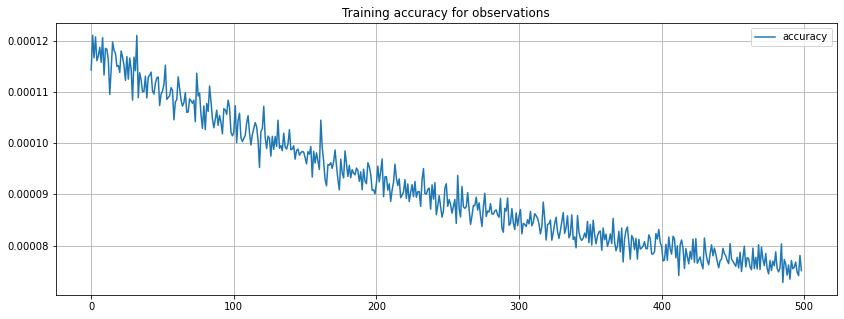

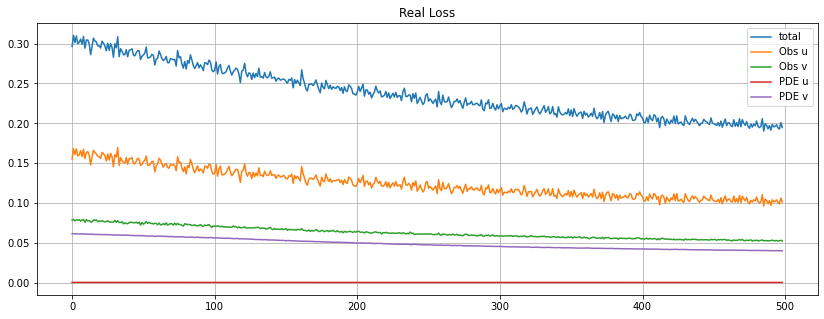

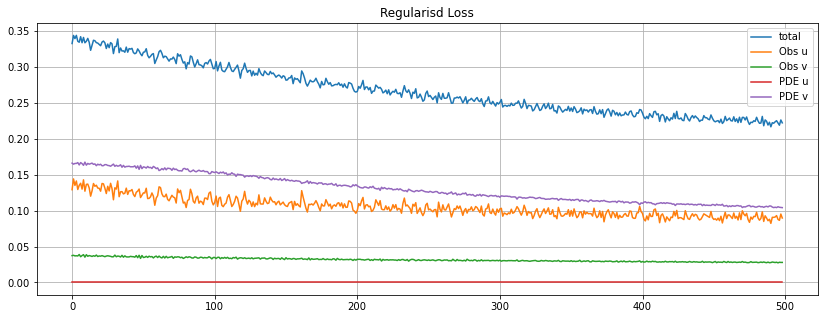

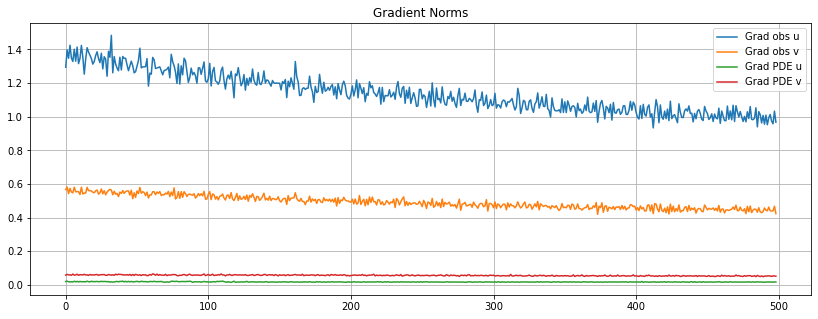

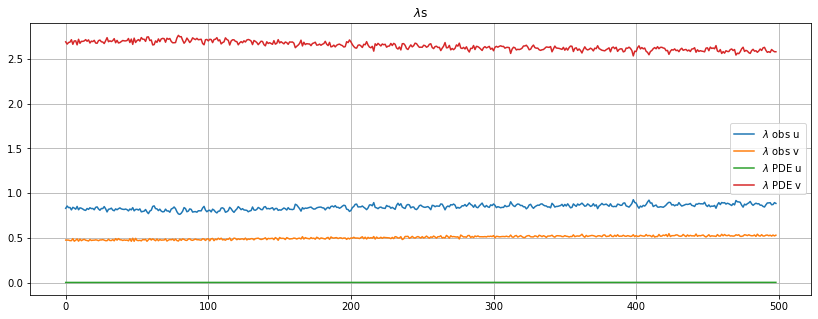

In [35]:
plot_result(results3, yscale='linear')

In [42]:
pinn3 = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss3 = ASDM(dtype=tf.float64, D_a=1, D_s=1, init_value=1.0)

In [43]:
model3 = tu.TINN(pinn3, 
                pde_loss3,                 
                alpha = 0.5, 
                print_precision=".8f")

In [44]:
results3_1 = model3.train(epochs = 200,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 0.13637294
total loss: 299.93667170, total regularisd loss: 299.93667170
obs u loss: 255.69055668, obs v loss: 30.41522699
pde u loss: 6.06461462, pde v loss: 7.76627341
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
sigma_a: 0.78506 sigma_s: 0.78181 mu_a: 1.25936 rho_a: 0.74282 
rho_s: 1.22260 kappa_a: 0.99058 
Time taken: 52.08s

Start of epoch 1
Training observations acc over epoch: 0.13217454
total loss: 271.06867448, total regularisd loss: 271.06867448
obs u loss: 247.94505974, obs v loss: 22.74844143
pde u loss: 0.28129529, pde v loss: 0.09387802
lambda obs u: 2.46786057, lambda obs v: 0.53213171
lambda pde u: 0.50000671, lambda pde v: 0.50000101
sigma_a: 0.78092 sigma_s: 0.77929 mu_a: 1.25555 rho_a: 0.74142 
rho_s: 1.22194 kappa_a: 0.99067 
Time taken: 32.87s

Start of epoch 2
Training observations acc over epoch: 0.13235995
total loss: 272.28409242, total regularisd lo

Training observations acc over epoch: 0.13216355
total loss: 271.60201401, total regularisd loss: 983.16971306
obs u loss: 247.80150300, obs v loss: 22.86946341
pde u loss: 0.60615171, pde v loss: 0.32489589
lambda obs u: 3.96169800, lambda obs v: 0.03823150
lambda pde u: 0.00005584, lambda pde v: 0.00001466
sigma_a: 0.71959 sigma_s: 0.72982 mu_a: 1.19580 rho_a: 0.76790 
rho_s: 1.16930 kappa_a: 1.03418 
Time taken: 27.12s

Start of epoch 20
Training observations acc over epoch: 0.13215616
total loss: 271.59009146, total regularisd loss: 982.51013663
obs u loss: 247.78152640, obs v loss: 22.87432551
pde u loss: 0.61118483, pde v loss: 0.32305473
lambda obs u: 3.96125146, lambda obs v: 0.03868421
lambda pde u: 0.00005197, lambda pde v: 0.00001235
sigma_a: 0.70711 sigma_s: 0.72924 mu_a: 1.19263 rho_a: 0.76436 
rho_s: 1.16746 kappa_a: 1.03180 
Time taken: 26.82s

Start of epoch 21
Training observations acc over epoch: 0.13220130
total loss: 271.74893293, total regularisd loss: 982.49842555

Training observations acc over epoch: 0.13209133
total loss: 270.99826603, total regularisd loss: 981.43462831
obs u loss: 247.75650780, obs v loss: 22.76633744
pde u loss: 0.23648967, pde v loss: 0.23893112
lambda obs u: 3.95231421, lambda obs v: 0.04766580
lambda pde u: 0.00001155, lambda pde v: 0.00000843
sigma_a: 0.35940 sigma_s: 0.62058 mu_a: 0.89700 rho_a: 0.82331 
rho_s: 0.93833 kappa_a: 0.93390 
Time taken: 27.25s

Start of epoch 39
Training observations acc over epoch: 0.13212101
total loss: 271.11367655, total regularisd loss: 980.29190220
obs u loss: 247.75451994, obs v loss: 22.82950310
pde u loss: 0.28452617, pde v loss: 0.24512734
lambda obs u: 3.95454260, lambda obs v: 0.04543857
lambda pde u: 0.00001094, lambda pde v: 0.00000789
sigma_a: 0.34486 sigma_s: 0.60862 mu_a: 0.88216 rho_a: 0.82584 
rho_s: 0.92980 kappa_a: 0.93486 
Time taken: 26.78s

Start of epoch 40
Training observations acc over epoch: 0.13207389
total loss: 270.92044907, total regularisd loss: 980.74376510

Training observations acc over epoch: 0.13203743
total loss: 270.63643089, total regularisd loss: 980.82055622
obs u loss: 247.71830623, obs v loss: 22.69428807
pde u loss: 0.10740880, pde v loss: 0.11642779
lambda obs u: 3.94504062, lambda obs v: 0.05495167
lambda pde u: 0.00000376, lambda pde v: 0.00000395
sigma_a: 0.17063 sigma_s: 0.49040 mu_a: 0.70910 rho_a: 0.84227 
rho_s: 0.77376 kappa_a: 1.00273 
Time taken: 26.58s

Start of epoch 58
Training observations acc over epoch: 0.13205783
total loss: 270.68600622, total regularisd loss: 978.48230073
obs u loss: 247.71165626, obs v loss: 22.74279386
pde u loss: 0.11715839, pde v loss: 0.11439770
lambda obs u: 3.94600130, lambda obs v: 0.05399155
lambda pde u: 0.00000358, lambda pde v: 0.00000357
sigma_a: 0.16417 sigma_s: 0.48763 mu_a: 0.70155 rho_a: 0.84315 
rho_s: 0.76740 kappa_a: 1.00507 
Time taken: 26.93s

Start of epoch 59
Training observations acc over epoch: 0.13204871
total loss: 270.65870392, total regularisd loss: 978.68421202

Training observations acc over epoch: 0.13206089
total loss: 270.62424350, total regularisd loss: 978.00045026
obs u loss: 247.70458650, obs v loss: 22.75606018
pde u loss: 0.07732188, pde v loss: 0.08627494
lambda obs u: 3.94638831, lambda obs v: 0.05360761
lambda pde u: 0.00000170, lambda pde v: 0.00000238
sigma_a: 0.08600 sigma_s: 0.42775 mu_a: 0.61618 rho_a: 0.84783 
rho_s: 0.68958 kappa_a: 1.04049 
Time taken: 26.69s

Start of epoch 77
Training observations acc over epoch: 0.13210125
total loss: 270.72810892, total regularisd loss: 978.88433367
obs u loss: 247.73580351, obs v loss: 22.80747717
pde u loss: 0.08608177, pde v loss: 0.09874647
lambda obs u: 3.94996728, lambda obs v: 0.05002853
lambda pde u: 0.00000177, lambda pde v: 0.00000243
sigma_a: 0.08441 sigma_s: 0.42682 mu_a: 0.61186 rho_a: 0.84840 
rho_s: 0.68460 kappa_a: 1.04266 
Time taken: 27.12s

Start of epoch 78
Training observations acc over epoch: 0.13203722
total loss: 270.55532231, total regularisd loss: 979.57102945

Training observations acc over epoch: 0.13204795
total loss: 270.55346034, total regularisd loss: 978.51985582
obs u loss: 247.70385068, obs v loss: 22.73035392
pde u loss: 0.05719793, pde v loss: 0.06205781
lambda obs u: 3.94643190, lambda obs v: 0.05356537
lambda pde u: 0.00000108, lambda pde v: 0.00000165
sigma_a: 0.04519 sigma_s: 0.39187 mu_a: 0.56805 rho_a: 0.85096 
rho_s: 0.63824 kappa_a: 1.06496 
Time taken: 27.03s

Start of epoch 96
Training observations acc over epoch: 0.13205166
total loss: 270.56010344, total regularisd loss: 978.78560884
obs u loss: 247.70931228, obs v loss: 22.73254067
pde u loss: 0.05342695, pde v loss: 0.06482354
lambda obs u: 3.94477613, lambda obs v: 0.05522109
lambda pde u: 0.00000105, lambda pde v: 0.00000173
sigma_a: 0.04286 sigma_s: 0.39019 mu_a: 0.56688 rho_a: 0.85064 
rho_s: 0.63625 kappa_a: 1.06608 
Time taken: 26.84s

Start of epoch 97
Training observations acc over epoch: 0.13206711
total loss: 270.60286211, total regularisd loss: 978.39886984

Training observations acc over epoch: 0.13203312
total loss: 270.49748301, total regularisd loss: 977.82044173
obs u loss: 247.70967137, obs v loss: 22.69412292
pde u loss: 0.04157765, pde v loss: 0.05211107
lambda obs u: 3.93873402, lambda obs v: 0.06126390
lambda pde u: 0.00000077, lambda pde v: 0.00000131
sigma_a: 0.01862 sigma_s: 0.36845 mu_a: 0.53867 rho_a: 0.85219 
rho_s: 0.60299 kappa_a: 1.08132 
Time taken: 27.34s

Start of epoch 115
Training observations acc over epoch: 0.13203421
total loss: 270.49775209, total regularisd loss: 977.06578926
obs u loss: 247.71297622, obs v loss: 22.69302477
pde u loss: 0.04223146, pde v loss: 0.04951964
lambda obs u: 3.93723245, lambda obs v: 0.06276541
lambda pde u: 0.00000081, lambda pde v: 0.00000133
sigma_a: 0.01745 sigma_s: 0.36769 mu_a: 0.53741 rho_a: 0.85229 
rho_s: 0.60145 kappa_a: 1.08196 
Time taken: 27.32s

Start of epoch 116
Training observations acc over epoch: 0.13203780
total loss: 270.50063740, total regularisd loss: 976.725416

Training observations acc over epoch: 0.13202144
total loss: 270.45687655, total regularisd loss: 978.52882528
obs u loss: 247.69297488, obs v loss: 22.68679965
pde u loss: 0.03474962, pde v loss: 0.04235240
lambda obs u: 3.94123972, lambda obs v: 0.05875856
lambda pde u: 0.00000062, lambda pde v: 0.00000110
sigma_a: 0.00010 sigma_s: 0.35002 mu_a: 0.51853 rho_a: 0.85283 
rho_s: 0.57831 kappa_a: 1.09263 
Time taken: 26.94s

Start of epoch 134
Training observations acc over epoch: 0.13202968
total loss: 270.47607349, total regularisd loss: 977.58794351
obs u loss: 247.70237522, obs v loss: 22.69461958
pde u loss: 0.03591348, pde v loss: 0.04316521
lambda obs u: 3.94155684, lambda obs v: 0.05844144
lambda pde u: 0.00000060, lambda pde v: 0.00000112
sigma_a: 0.00025 sigma_s: 0.34965 mu_a: 0.51795 rho_a: 0.85269 
rho_s: 0.57697 kappa_a: 1.09325 
Time taken: 26.73s

Start of epoch 135
Training observations acc over epoch: 0.13204721
total loss: 270.51833633, total regularisd loss: 977.696580

Training observations acc over epoch: 0.13202299
total loss: 270.45703972, total regularisd loss: 977.54251589
obs u loss: 247.69163086, obs v loss: 22.69148737
pde u loss: 0.03483565, pde v loss: 0.03908584
lambda obs u: 3.94020502, lambda obs v: 0.05979342
lambda pde u: 0.00000059, lambda pde v: 0.00000097
sigma_a: 0.00012 sigma_s: 0.33609 mu_a: 0.51164 rho_a: 0.84662 
rho_s: 0.55683 kappa_a: 1.10401 
Time taken: 26.52s

Start of epoch 153
Training observations acc over epoch: 0.13205250
total loss: 270.52567202, total regularisd loss: 977.38588584
obs u loss: 247.70958541, obs v loss: 22.73382476
pde u loss: 0.04087310, pde v loss: 0.04138875
lambda obs u: 3.94432067, lambda obs v: 0.05567775
lambda pde u: 0.00000061, lambda pde v: 0.00000097
sigma_a: 0.00052 sigma_s: 0.33618 mu_a: 0.51122 rho_a: 0.84632 
rho_s: 0.55539 kappa_a: 1.10460 
Time taken: 26.06s

Start of epoch 154
Training observations acc over epoch: 0.13205160
total loss: 270.52415449, total regularisd loss: 978.296255

Training observations acc over epoch: 0.13201696
total loss: 270.44106088, total regularisd loss: 977.44651445
obs u loss: 247.68452530, obs v loss: 22.68614737
pde u loss: 0.03552321, pde v loss: 0.03486500
lambda obs u: 3.93922429, lambda obs v: 0.06077416
lambda pde u: 0.00000067, lambda pde v: 0.00000088
sigma_a: 0.00014 sigma_s: 0.32460 mu_a: 0.50584 rho_a: 0.84009 
rho_s: 0.53940 kappa_a: 1.11211 
Time taken: 26.85s

Start of epoch 172
Training observations acc over epoch: 0.13202904
total loss: 270.46981234, total regularisd loss: 977.11613520
obs u loss: 247.69767386, obs v loss: 22.69781453
pde u loss: 0.03827184, pde v loss: 0.03605210
lambda obs u: 3.93989189, lambda obs v: 0.06010652
lambda pde u: 0.00000068, lambda pde v: 0.00000092
sigma_a: 0.00034 sigma_s: 0.32395 mu_a: 0.50534 rho_a: 0.83981 
rho_s: 0.53866 kappa_a: 1.11237 
Time taken: 26.60s

Start of epoch 173
Training observations acc over epoch: 0.13201693
total loss: 270.44016065, total regularisd loss: 977.221820

Training observations acc over epoch: 0.13200839
total loss: 270.44935844, total regularisd loss: 979.94527412
obs u loss: 247.57749341, obs v loss: 22.77553754
pde u loss: 0.04584643, pde v loss: 0.05048106
lambda obs u: 3.95458159, lambda obs v: 0.04541666
lambda pde u: 0.00000063, lambda pde v: 0.00000112
sigma_a: 0.00020 sigma_s: 0.31377 mu_a: 0.49969 rho_a: 0.83250 
rho_s: 0.52238 kappa_a: 1.11903 
Time taken: 26.99s

Start of epoch 191
Training observations acc over epoch: 0.13196091
total loss: 270.37264658, total regularisd loss: 979.50579936
obs u loss: 247.42667344, obs v loss: 22.82934132
pde u loss: 0.04896130, pde v loss: 0.06767053
lambda obs u: 3.95613842, lambda obs v: 0.04385934
lambda pde u: 0.00000065, lambda pde v: 0.00000158
sigma_a: 0.00000 sigma_s: 0.31264 mu_a: 0.49947 rho_a: 0.83192 
rho_s: 0.52037 kappa_a: 1.12011 
Time taken: 26.67s

Start of epoch 192
Training observations acc over epoch: 0.13184714
total loss: 270.17723149, total regularisd loss: 978.815906

In [69]:
pde_loss_exp4.print_precision=".10f"
print(pde_loss_exp4.trainables_str())

sigma_a: 0.0000000000 sigma_s: 0.0173612590 mu_a: 0.0101293428 rho_a: 0.0106398708 
rho_s: 0.0184814247 kappa_a: 0.3064100920 
